<a href="https://colab.research.google.com/github/anjilab/google-colab-run/blob/persuasion-detection/Copy_of_detection_persuasion_techniques_memes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Detection of Persuasion Techniques in Texts and Images

It is the task of detecting if a meme tries to persuade a person into believing some propagandist claim. Such propaganda campaigns are often carried out using posts spread on social media, with the aim to reach very large audience. The task is divided into three subtaks:
1. Given the textual content of a meme, identify the techniques used in it (multilabel classification problem).
2. Given the textual content of a meme, identify the techniques in it together with the span(s) of text in which each propaganda techniques appear
3. Given a meme, identify all techniques used in the meme, including the text and the visual content (multimodal task). This is a multilabel classification problem.

The techniques used are explained in each Subtask paragraph.

All of them are implemented using [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/starter/introduction.html).

The metrics used to evaluate the performances of the models are F1-micro and F1-macro.

$F1$-$score = 2 * \frac{Precision * Recall}{Precision + Recall}$

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + FN}$

The macro F1 score is computed by taking the arithmetic mean of all the F1-scores computed for each class.

The micro F1 score is computed considering the sums of all the TP (True Positives), FN (False Negatives), and FP (False Positives) across all classes.

The pre-trained language models are taken from [Hugging Face](https://huggingface.co/).

All the code of the project has been beautified to let it adhere to PEP8 with auto pep8 extension of VScode.

The implemented techniques can be all considered state of the art for the tasks, since they're inspired by the top-ranked teams' models in SemEval-2021 Task6 challenge and they're all based on transformers (BERT-like) that are considered SOTA in NLP tasks.

# Import

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
#  pip install  "datasets" "transformers" "pytorch-lightning"

In [1]:
import torch
from torch.utils.data import (
    Dataset, TensorDataset,
    DataLoader, RandomSampler,
    SequentialSampler)
import torch.nn as nn
import torchmetrics
import torchmetrics.functional as func

from pytorch_lightning import (
    LightningDataModule, LightningModule,
    Trainer, seed_everything)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.base import Callback
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_constant_schedule_with_warmup,
    MMBTConfig,
    MMBTModel,
    VisualBertModel
)
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
from torchvision import transforms, models
from torchvision.models import detection
import cv2
from PIL import Image

In [ ]:
from tqdm import tqdm

In [ ]:
import csv
import gc
import json
import re
import numpy as np
import pandas as pd
import random

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, num_classes=14, title='confusion matrix',
                          classes=['negative', 'positive'], cmap=plt.cm.YlGn):

    title = title

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(num_classes-0.5, -0.5)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def plot_confusion_multi(all_cm, classes):
  assert len(all_cm)==len(classes)
  label =0
  for cm in all_cm:
    class_name=classes[label]
    title="confusion matrix for "+str(class_name)
    plot_confusion_matrix(cm,2,title=title)
    label=label+1

In [ ]:
AVAIL_GPUS = 0
if torch.cuda.is_available():
    device = torch.device("cuda")
    AVAIL_GPUS = torch.cuda.device_count()
    print(f'There are {AVAIL_GPUS} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
seed_everything(42)

# Main Folders

In order to run the whole code it is necessary to add a shortcut from the shared folder "DeepProject" to "MyDrive" folder, or change the **folder_name** variable, setting it to the right path.

In [ ]:
folder_name = "/content/drive/MyDrive/DeepProject/"
logs_dir = folder_name + "Logs/"

# Pre-trained Transformer Name

This section is used to choose which pre-trained model to load from HuggingFace library.

In [ ]:
pretrained_transformer_name = "bert-base-cased"
#pretrained_transformer_name = "xlnet-base-cased"
#pretrained_transformer_name = "microsoft/deberta-base"
#pretrained_transformer_name = "albert-base-v2"
#pretrained_transformer_name = "roberta-base"

checkpoint_name= pretrained_transformer_name.replace("/","_")

# PTC: Propaganda Techniques corpus
For Subtask1 and Subtask2 **transfer learning** is applied: the language models are pre-trained on PTC articles corpus from [PTC TASKS ON
"DETECTION OF PROPAGANDA TECHNIQUES IN NEWS ARTICLES" challenge](https://propaganda.math.unipd.it/ptc/) (task TC). It is a dataset that labels about 450 news articles into 14 propaganda techniques.


## Data pre-processing

We generated a multi-class dataset associating to each sentence a label, starting from PTC labeling of the spans in each news article, obtaining 6128 train samples and 1063 test samples.

In [ ]:
train_PTC_labels_file_name = folder_name + \
    "Dataset/PTC/train-task-flc-tc.labels"
train_articles_folder = folder_name + "Dataset/PTC/train-articles/"

train_PTC_dataset_file_name = folder_name + "Dataset/PTC_dataset.csv"

val_PTC_labels_file_name = folder_name + "Dataset/PTC/dev-task-flc-tc.labels"
val_articles_folder = folder_name + "Dataset/PTC/dev-articles/"

val_PTC_dataset_file_name = folder_name + "Dataset/PTC_validation_dataset.csv"

PTC_checkpoints= folder_name + "Model/PTC/"


Function used only once to create the csv dataset from the PTC articles corpus.

In [ ]:
def create_dataset(input_name, output_name, articles_folder):
    f_output = open(output_name, 'w')

    with open(input_name, 'r') as f:
        writer = csv.writer(f_output)
        writer.writerow(['text', 'label'])
        article_file_name = ""
        af = None
        for line in f:
            fields = line.split('\t')
            id_file = fields[0]
            label = fields[1]
            begin_offset = int(fields[2])
            end_offset = int(fields[3])
            file_name = articles_folder + "article" + id_file + ".txt"

            if(file_name != article_file_name):
                if(af != None):
                    af.close()
                article_file_name = articles_folder + "article" + id_file + ".txt"
                af = open(article_file_name, 'rb')

            af.seek(begin_offset)
            assert end_offset - begin_offset > 0
            text = af.read(
                end_offset - begin_offset).decode('utf-8', 'ignore').strip()
            text = re.sub('[^A-Za-z0-9!?()%-= \']+', '', text)

            writer.writerow([text, label])

    af.close()
    f.close()
    f_output.close()


In [ ]:
#create_dataset(train_PTC_labels_file_name,
#               train_PTC_dataset_file_name, train_articles_folder)
#create_dataset(val_PTC_labels_file_name,
#               val_PTC_dataset_file_name, val_articles_folder)

## PTC - Training

### Dataset

In [ ]:
class PTCDataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

In [ ]:
train_data = pd.read_csv(train_PTC_dataset_file_name)
val_data = pd.read_csv(val_PTC_dataset_file_name)

Overview of the dataset characteristics and of the distribution of the classes.

In [ ]:
train_data

In [ ]:
train_data.describe()

In [ ]:
frequences = train_data.groupby(['label']).size()
frequences

As we can see in the plot below, the distribution of the samples among the classes is not balanced. This means that we could expect good results for certain classes and bad for others or, in the worst scenario, our models could be heavily biased towards the classes which have more samples. To mitigate this problem we focused on trying different kinds of loss functions.

In [ ]:
frequences.plot(kind='bar')

### Define LightningDataModule

In the DataModule the sentences are encoded by a tokenizer that adds special tokens and padding, truncates to the maximum length (computed by the maxLen function) and returns the attention mask and the token ids.

We can pass the model's name as parameter to the DataModule, in this way the tokenizer's output is going to be appropriate for such model.

In [ ]:
class PTCDataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        val_data,
        model_name: str = "bert-base-uncased",
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.num_labels = 14
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.le = preprocessing.LabelEncoder()

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.le.fit(self.train_data.label.values)
        y_train = self.le.transform(self.train_data.label.values)

        self.X_val = self.val_data.text.values
        y_val = self.le.transform(self.val_data.label.values)

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = PTCDataset(self.X_train_enc,
                          self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = PTCDataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            encoded_sent = self.tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        return input_ids, attention_masks

    def maxLen(self):
        X_all = np.concatenate([self.X_train, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len


In [ ]:
seed_everything(42)
dm = PTCDataModule(train_data, val_data,
                   model_name=pretrained_transformer_name, batch_size=16)
dm.setup()

### Loss Functions

To deal with the unbalanced dataset, a first approach consisted in a weighted version of Cross Entropy which adds weights to positive samples in the loss function with the following formula (from [Volta at SemEval-2021 Task 6](https://arxiv.org/pdf/2106.00240.pdf)):

$l(x,y) = - \dfrac{1}{N}\sum_{n=1}^{N}[p^{y_n} \log(\frac{exp(x_{n}^{y_n})}{∑_{k=1}^d exp(x_n^k)})]$

where $p^k = \dfrac{1}{f^k}(|K| - f^k)$, $N$ is the batch size, $n$ is and index for the $n^{th}$ batch element, $d$ is the number of classes, $f$ stands for a vector of class absolute frequencies, $x$ is a vector from the last Sigmoid layer, y is a vector representing the labels and $|K|$ is the size of the train set.

In [ ]:
class WeightedCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedCELoss, self).__init__()
        self.y_train = y_train
        self.weight = self.weighted_factors()
        self.loss = torch.nn.CrossEntropyLoss(
            weight=self.weight, reduction='mean')

    def forward(self, logits, labels):
        return self.loss(logits, labels)

    def weighted_factors(self):
        f = torch.bincount(self.y_train)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        weight = torch.div(torch.sub(K, f), f).to(device=device)
        return weight

As second approach we use [Focal loss](https://arxiv.org/pdf/1708.02002.pdf) which focuses on improving predictions on hard misclassified examples.

This is achieved by adding two hyper-parameters to the cross entropy loss, $\alpha$ and $γ$, where $α$ controls the weight of positive and negative samples and $γ$ scales the loss of hard and easy samples.

So, for the $i^{th}$ class:
$L_{class_i}=\begin{cases}
-α(1-p)^γ\log(p),& \text{if y=1} \\
-(1-α)p^γ\log(1-p),& \text{otherwise}
\end{cases}
$, where $y$ is the ground truth and $p$ is the model's prediction.

In our experiments we noticed worse results for values of $α$ different from 1, so we deleted this parameter and kept just the focusing parameter $γ$.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.CE = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        CE_loss = self.CE(inputs,targets)
        pt = torch.exp(-CE_loss)
        F_loss = (1-pt)**self.gamma * CE_loss

        return torch.mean(F_loss)

### Model

Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class PTCEvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.detach().cpu().numpy().astype(np.int)
        all_labels = model.labels.detach().cpu().numpy().astype(np.int)

        classes = model.le.classes_

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(model.num_classes)], target_names=classes))

        conf_mat = confusion_matrix(all_labels, all_predictions)
        plot_confusion_matrix(conf_mat, classes=classes)

        return


In [ ]:
class CLSExtractor(nn.Module):
    def __init__(self, name):
        super(CLSExtractor, self).__init__()
        self.isCLSLast = (True if name == 'xlnet-base-cased' else False)

    def forward(self, x):
        if(self.isCLSLast):
            return x[0][:, -1, :]
        else:
            return x[0][:, 0, :]

In [ ]:
class PTCTransformer(LightningModule):
    def __init__(
        self,
        le,
        y_train=None,
        num_classes: int = 14,
        model_name_or_path: str = "bert-base-uncased",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon

        self.save_hyperparameters()

        self.le = le

        #self.loss = nn.CrossEntropyLoss()
        self.loss = FocalLoss()
        #self.loss = WeightedCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.labels = torch.Tensor(device=self.device)
        self.predictions = torch.Tensor(device=self.device)

        D_in, H, D_out = 768, 96, num_classes
        self.transformer = AutoModel.from_pretrained(model_name_or_path)

        self.extractor = CLSExtractor(model_name_or_path)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        plm_output = self.transformer(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"])

        last_hidden_state_cls = self.extractor(plm_output)

        logits = self.classifier(last_hidden_state_cls)

        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels)
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = torch.argmax(torch.softmax(logits, dim=1), axis=1)
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels)
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True, logger=True)
        predictions = torch.argmax(logits, axis=1)
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(),
                          lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


### Training

In [ ]:
model = PTCTransformer(
    dm.le, dm.y_train, model_name_or_path=pretrained_transformer_name)

In [ ]:
log_dir = logs_dir+"PTC/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="PTC_net_"+checkpoint_name, version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=3, gpus=AVAIL_GPUS, logger=logger, callbacks=[
                  PTCEvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

This command is used to save checkpoints needed for subtask 1.

It is commented to not overwrite the checkpoints of the best performing model already saved.

In [ ]:
# trainer.save_checkpoint(PTC_checkpoints+"PTC_"+checkpoint_name+"_FL.ckpt")

### Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/DeepProject/Logs/PTC/

### Experiments

From the experiments we made we established that the best parameters are the followings:

| Parameters (PTC) |          |
|:----------------:|:--------:|
|      Dropout     |   0.10   |
|    Batch Size    |    32    |
|   Learning Rate  | 2,00E-05 |
|     Optimizer    |   Adam   |
|   Adam Epsilon   | 1,00E-08 |
|      Epochs      |     3    |

We tested three different loss functions for each Pretrained Language Model (PLM) and we obtained the following results:

| Model (PTC) 	|      Loss      	|    DEV-SET   	|    DEV-SET   	|
|:-----------:	|:--------------:	|:------------:	|:------------:	|
|             	|                	| **F1-micro** 	| **F1-macro** 	|
|             	|  CrossEntropy  	|     0.37     	|     0.12     	|
|   **BERT**  	| WeightedCELoss 	|     0.25     	|     0.16     	|
|             	|    FocalLoss   	|     0.38     	|     0.13     	|
|             	|                	|              	|              	|
|             	|  CrossEntropy  	|     0.31     	|     0.03     	|
|  **ALBERT** 	| WeightedCELoss 	|     0.20     	|     0.05     	|
|             	|    FocalLoss   	|     0.36     	|     0.11     	|
|             	|                	|              	|              	|
|             	|  CrossEntropy  	|     0.39     	|     0.14     	|
| **RoBERTa** 	| WeightedCELoss 	|     0.24     	|     0.10     	|
|             	|    FocalLoss   	|     0.34     	|     0.08     	|
|             	|                	|              	|              	|
|             	|  CrossEntropy  	|     0.38     	|     0.13     	|
| **DeBERTa** 	| WeightedCELoss 	|     0.22     	|     0.10     	|
|             	|    FocalLoss   	|     0.36     	|     0.11     	|
|             	|                	|              	|              	|
|             	|  CrossEntropy  	|     0.36     	|     0.12     	|
|  **XLNet**  	| WeightedCELoss 	|     0.23     	|     0.11     	|
|             	|    FocalLoss   	|     0.37     	|     0.12     	|

Given the results shown in the last table, we are going to use the following models for transfer learning in Subtask1:


*   BERT with Focal Loss
*   ALBERT with Focal Loss
*   RoBERTa with Cross Entropy Loss
*   DeBERTa with Cross Entropy Loss
*   XLNet with Focal Loss



# Subtask 1
Given the textual content of a meme, identify which of the 20 techniques are used in it (multilabel classification problem)

The main paper from which we got inspired is: [MinD at SemEval-2021 Task 6](https://aclanthology.org/2021.semeval-1.150.pdf), which ranked first in the challenge.

The approach used from the MinD team consists in fine tuning different pre-trained transformers models and then ensemble them to obtain the final predictions by averaging the probabilities from the models.

The models we fine-tuned are the ones obtained from the previous section (PTC).

The official evaluation measure for this subtask is micro-F1.


In [ ]:
gc.collect()

In [ ]:
Task1_checkpoints= folder_name + "Model/SubTask1/"

## Dataset

The train, dev and test datasets contain 688, 63 and 200 memes respectively.

The distribution of samples among the classes is highly unbalanced (similarly to PTC's dataset).

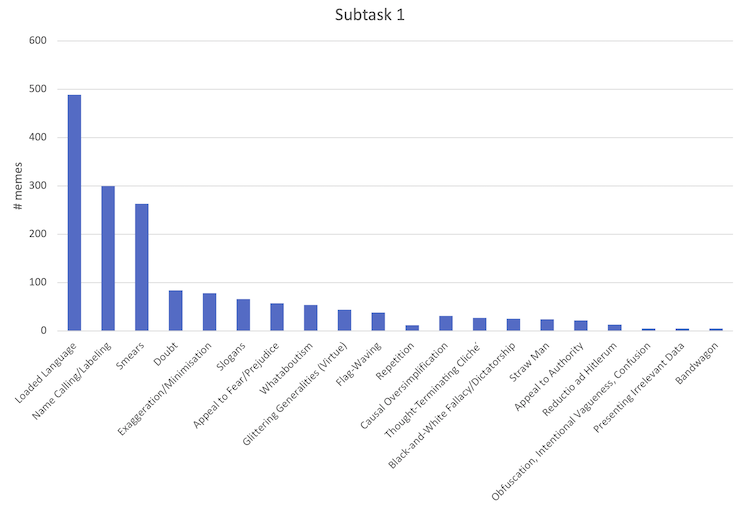

In [ ]:
dataset_folder=folder_name+"/Dataset/data/"
train_st1 = dataset_folder+"training_set_task1.txt"
dev_st1 = dataset_folder+"dev_set_task1.txt"
test_st1 = dataset_folder+"test_set_task1.txt"

In [ ]:
train_data1=pd.read_json(train_st1)
dev_data1=pd.read_json(dev_st1)
test_data1=pd.read_json(test_st1)

In [ ]:
train_data1

In [ ]:
print("Number of samples in the train dataset: {}, validation dataset: {} and test dataset: {}".format(len(train_data1.text.values), len(dev_data1.text.values), len(test_data1.text.values)))

In [ ]:
techniques = [['Appeal to authority', 'Appeal to fear/prejudice', 'Bandwagon',
               'Black-and-white Fallacy/Dictatorship',
               'Causal Oversimplification', 'Doubt', 'Exaggeration/Minimisation',
               'Flag-waving', 'Glittering generalities (Virtue)',
               'Loaded Language',
               "Misrepresentation of Someone's Position (Straw Man)",
               'Name calling/Labeling',
               'Obfuscation, Intentional vagueness, Confusion',
               'Presenting Irrelevant Data (Red Herring)', 'Reductio ad hitlerum',
               'Repetition', 'Slogans', 'Smears', 'Thought-terminating cliché',
               'Whataboutism']]

In [ ]:
class Task1Dataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

##Random Baseline

Random baseline from SEMEVAL-2021-task6: [GitHub link](https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/blob/main/baselines/baseline_task1_random.py)

In [ ]:
random.seed(42)

In [ ]:
def get_predictions(data):
    all_predictions = []
    for sample in data:
        prediction = []
        i = 0
        techniques_names = techniques[0][:]
        while i < len(techniques_names) and random.random() < 0.5:
            random_technique = techniques_names[random.randint(
                0, len(techniques_names)-1)]
            prediction.append(random_technique)
            techniques_names.remove(random_technique)
            i += 1
        all_predictions.append(prediction)
    return all_predictions

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(techniques)

In [ ]:
print("DEV RANDOM BASELINE SCORES: ")
dev_predictions = get_predictions(dev_data1.text.values)
preds = mlb.transform(dev_predictions)
labels = mlb.transform(dev_data1.labels.values)
print("F1-micro: {}".format(f1_score(labels, preds, average="micro", zero_division=1)))
print("F1-macro: {}".format(f1_score(labels, preds, average="macro", zero_division=1)))

In [ ]:
print("TEST RANDOM BASELINE SCORES: ")
test_predictions = get_predictions(test_data1.text.values)
preds = mlb.transform(test_predictions)
labels = mlb.transform(test_data1.labels.values)
print("F1-micro: {}".format(f1_score(labels, preds, average="micro", zero_division=1)))
print("F1-macro: {}".format(f1_score(labels, preds, average="macro", zero_division=1)))

##Loss Functions

To deal with this unbalanced dataset, we tried to use several loss functions that could handle such disparities.

A first approach consisted in a weighted version of Binary Cross Entropy which adds weights to positive samples in the loss function with the following formula (from [Volta at SemEval-2021 Task 6](https://arxiv.org/pdf/2106.00240.pdf)):

$l(x,y) = - \dfrac{1}{Nd}\sum_{n=1}^{N}\sum_{k=1}^{d}[p^k y_n^k \log(x_n^k) + (1 - y_n^k)\log(1-x_n^k)]$

where $p^k = \dfrac{1}{f^k}(|K| - f^k)$, $N$ is the batch size, $n$ is and index for the $n^{th}$ batch element, $d$ is the number of classes, $f$ stands for a vector of class absolute frequencies, $x$ is a vector from the last Sigmoid layer, y is a vector representing the labels and $|K|$ is the size of the train set.

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedBCELoss, self).__init__()
        self.y_train = y_train
        self.pos_weight = self.weighted_factors()

    def forward(self, logits, labels):
        loss = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight, reduction='mean')
        return loss(logits, labels)

    def weighted_factors(self):
        f = torch.sum(self.y_train, dim=0)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        pos_weight = torch.div(torch.sub(K, f), f).to(device=device)
        return pos_weight

As second approach we use [Focal loss](https://arxiv.org/pdf/1708.02002.pdf) which focuses on improving predictions on hard misclassified examples.

This is achieved by adding the two hyper-parameters to the cross entropy loss, $\alpha$ and $γ$, where $α$ controls the weight of positive and negative samples and $γ$ scales the loss of hard and easy samples.

So, for the $i^{th}$ class:
$L_{class_i}=\begin{cases}
α(1-p)^γ\log(p),& \text{if y=1} \\
(1-α)p^γ\log(1-p),& \text{otherwise}
\end{cases}
$, where $y$ is the ground truth and $p$ is the model's prediction.

In our experiments we noticed worse results for values of $α$ different from 1, so we deleted this parameter and kept just the focusing parameter $γ$.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        #self.alpha = alpha
        self.gamma = gamma
        self.BCE = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.BCE(inputs,targets)
        pt = torch.exp(-BCE_loss)
        #F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        F_loss =  (1-pt)**self.gamma * BCE_loss

        return torch.mean(F_loss)

## Lightning DataModule

In [ ]:
class Task1DataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        test_data,
        val_data,
        techniques,
        num_classes: int = 20,
        model_name: str = "bert-base-uncased",
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.mlb = MultiLabelBinarizer()

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.mlb.fit(self.techniques)
        y_train = self.mlb.transform(self.train_data.labels.values)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_val = self.val_data.text.values
        y_val = self.mlb.transform(self.val_data.labels.values)

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)
        self.X_test_enc, self.X_test_attention = self.preprocessing(
            self.X_test)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)
        self.y_test = torch.tensor(y_test)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = Task1Dataset(
            self.X_train_enc, self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = Task1Dataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def test_dataloader(self):
        data = Task1Dataset(
            self.X_test_enc, self.X_test_attention, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = self.tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        return input_ids, attention_masks

    def maxLen(self):
        tmp = np.concatenate([self.X_train, self.X_test])
        X_all = np.concatenate([tmp, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len

In [ ]:
dm = Task1DataModule(train_data1, test_data1, dev_data1, techniques=techniques,
                      model_name=pretrained_transformer_name, batch_size=8)
dm.setup()

## Subtask 1 Model

Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class Task1EvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def on_test_end(self, trainer, model):
        print("Test metrics:")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def print_evaluation(self, all_predictions, all_labels, classes, num_classes):
        all_predictions = all_predictions.detach().cpu()
        all_labels = all_labels.detach().cpu()

        confMatrix = torchmetrics.ConfusionMatrix(
            num_classes=num_classes, multilabel=True)
        conf_mat = confMatrix(all_predictions, all_labels)
        plot_confusion_multi(conf_mat, classes)

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average="micro", zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average="macro", zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(num_classes)], target_names=classes, zero_division=1))

        return

In this section we load the transformer model previously trained on PTC dataset by passing its name as input to the Task1Model class and then we add a classifier on top of it that takes the [CLS] token from the transformer as input. This classifier is composed by two layers with Dropout and as activation function ReLU.

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class Task1Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 20,
        model_name_or_path: str = "bert-base-cased",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 500,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        #self.loss = torch.nn.BCEWithLogitsLoss()
        self.loss = FocalLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        D_in, H, D_out = 768, 96, self.num_classes
        loaded_model = PTCTransformer.load_from_checkpoint(
            checkpoint_path=PTC_checkpoints+"PTC_"+model_name_or_path+"_FL.ckpt")
        self.transformer = loaded_model
        self.transformer.classifier = Identity()

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        cls_output = self.transformer(**inputs)
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)
        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                           lr=self.learning_rate, eps=self.adam_epsilon)

        return [optimizer]

        #optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        #scheduler = get_constant_schedule_with_warmup(
        #    optimizer, num_warmup_steps=self.warmup_steps)
        #return dict(
        #    optimizer=optimizer,
        #    lr_scheduler=dict(
        #        scheduler=scheduler,
        #        interval="step")
        #)


## Train and Validation

In [ ]:
model = Task1Model(dm.mlb, dm.y_train,
                         model_name_or_path=checkpoint_name)

In [ ]:
log_dir = logs_dir+"SubTask1/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask1_net_"+checkpoint_name, version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger, callbacks=[
                  Task1EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

This command is used to save checkpoints needed for the ensemble.

It is commented to not overwrite the checkpoints of the best performing model already saved.

In [ ]:
#trainer.save_checkpoint(Task1_checkpoints+"SubTask1_"+checkpoint_name+"_FL.ckpt")

## Testing

In [ ]:
trainer.test(model, dm)

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/DeepProject/Logs/SubTask1/

## Example prediction


Print some predictions made from the model on few samples and their true labels.

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
for i in range(5):
    text = test_data1.text.values[i].replace(
        '\\', "").replace('\n', ' ').strip()
    labels = test_data1.labels.values[i]
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## Experiments and Results

The best results are obtained with the following configuration of the main parameters:

| Parameters (TASK 1) 	|          	|
|:-------------------:	|:--------:	|
|       Dropout       	|   0.10   	|
|      Batch Size     	|     8    	|
|    Learning Rate    	| 2,00E-05 	|
|      Optimizer      	|   AdamW  	|
|    Warm Up Steps    	|    500   	|
|     Weight Decay    	|    0.1   	|
|     Adam Epsilon    	| 1,00E-08 	|
|        Epochs       	|    10    	|

In the following tables are reported some of the tests done for this subtask.

Models fine-tuned on PTC are slightly better than the ones that are taken directly from HuggingFace library.


|          Model         	| Epochs 	|       Loss      	| F1 micro 	| F1 macro 	| F1 micro test 	| F1 macro test 	|
|:----------------------:	|:------:	|:---------------:	|:--------:	|:--------:	|:-------------:	|:-------------:	|
| **Bert base (no PTC)** 	|   10   	|    Focal loss   	|   0.47   	|   0.24   	|      0.38     	|      0.06     	|
| **Bert base (no PTC)** 	|   20   	| WeightedBCELoss 	|   0.46   	|   0.33   	|      0.37     	|      0.13     	|
|                        	|        	|                 	|          	|          	|               	|               	|
|   **Bert base (PTC)**  	|   10   	|    Focal loss   	|   0.53   	|   0.31   	|      0.47     	|      0.10     	|
|   **Bert base (PTC)**  	|   20   	| WeightedBCELoss 	|   0.53   	|   0.37   	|      0.44     	|      0.20     	|

In general models with Focal Loss got better results compared to plain BCE Loss and Weighted BCE Loss.

AdamW and Adam got very similar results.

The model that has the best F1-score is DeBerta base, but this was predictable since it is the biggest model.

|    Model (TASK 1)   	|       Loss       	|    DEV-SET   	|              	|   TEST-SET   	|              	|        Scheduler       	|
|:-------------------:	|:----------------:	|:------------:	|:------------:	|:------------:	|:------------:	|:----------------------:	|
|                     	|                  	| **F1-micro** 	| **F1-macro** 	| **F1-micro** 	| **F1-macro** 	|                        	|
|       **BERT**      	|        BCE       	|     0.53     	|     0.25     	|     0.47     	|     0.08     	|            -           	|
|                     	|                  	|     0.54     	|     0.25     	|     0.47     	|     0.09     	| Constant  with warmups 	|
|       **BERT**      	|  WeightedBCELoss 	|     0.45     	|     0.31     	|     0.36     	|     0.18     	|            -           	|
|                     	|                  	|     0.38     	|     0.24     	|     0.33     	|     0.17     	| Constant  with warmups 	|
|       **BERT**      	|     FocalLoss    	|     0.53     	|     0.31     	|     0.47     	|     0.10     	|            -           	|
|                     	|                  	|     0.51     	|     0.24     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|      **ALBERT**     	|        BCE       	|     0.57     	|     0.25     	|     0.49     	|     0.08     	|            -           	|
|                     	|                  	|     0.53     	|     0.24     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|      **ALBERT**     	|  WeightedBCELoss 	|     0.48     	|     0.30     	|     0.43     	|     0.15     	|            -           	|
|                     	|                  	|     0.44     	|     0.28     	|     0.40     	|     0.19     	| Constant  with warmups 	|
|      **ALBERT**     	|     FocalLoss    	|     0.56     	|     0.27     	|     0.50     	|     0.10     	|            -           	|
|                     	|                  	|     0.53     	|     0.28     	|     0.50     	|     0.11     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|     **RoBERTa**     	|        BCE       	|     0.55     	|     0.25     	|     0.48     	|     0.08     	|            -           	|
|                     	|                  	|     0.52     	|     0.24     	|     0.47     	|     0.08     	| Constant  with warmups 	|
|     **RoBERTa**     	|  WeightedBCELoss 	|     0.50     	|     0.33     	|     0.36     	|     0.19     	|            -           	|
|                     	|                  	|     0.42     	|     0.26     	|     0.36     	|     0.20     	| Constant  with warmups 	|
|     **RoBERTa**     	|     FocalLoss    	|     0.55     	|     0.30     	|     0.49     	|     0.12     	|            -           	|
|                     	|                  	|     0.49     	|     0.27     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|     **DeBERTa**     	|        BCE       	|     0.51     	|     0.24     	|     0.50     	|     0.09     	|            -           	|
|                     	|                  	|     0.53     	|     0.23     	|     0.46     	|     0.08     	| Constant  with warmups 	|
|     **DeBERTa**     	| WeightedBCELoss  	|     0.56     	|     0.50     	|     0.41     	|     0.24     	|            -           	|
|                     	|                  	|     0.47     	|     0.33     	|     0.38     	|     0.22     	| Constant  with warmups 	|
|     **DeBERTa**     	|    FocalLoss     	|     0.57     	|     0.33     	|     0.52     	|     0.13     	|            -           	|
|                     	|                  	|     0.60     	|     0.32     	|     0.49     	|     0.13     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|      **XLNet**      	|        BCE       	|     0.50     	|     0.30     	|     0.49     	|     0.13     	|            -           	|
|                     	|                  	|     0.50     	|     0.26     	|     0.48     	|     0.10     	| Constant  with warmups 	|
|      **XLNet**      	|  WeightedBCELoss 	|     0.55     	|     0.33     	|     0.43     	|     0.21     	|            -           	|
|                     	|                  	|     0.44     	|     0.33     	|     0.38     	|     0.21     	| Constant  with warmups 	|
|      **XLNet**      	|     FocalLoss    	|     0.54     	|     0.35     	|     0.49     	|     0.13     	|            -           	|
|                     	|                  	|     0.58     	|     0.33     	|     0.44     	|     0.10     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
| **Random Baseline** 	|                  	|     0.06     	|     0.04     	|     0.05     	|     0.03     	|                        	|

## Ensemble

We ensembled the best single models with two strategies:
* Mean: the ensembler computes the mean of the predictions of the models and then applies a sigmoid and the threshold to get its final prediction.
* Majority voting: the ensembler takes the predictions of the model, applies a sigmoid and the threshold and then takes as final prediction the most voted label.

For the ensemble we needed to define new classes for the Dataset and DataModule.

The dataset consists in a dictionary, built in the DataModule, in which a key is the name of a model and the value is a dictionary that stores input ids and attention mask for the model.

In [ ]:
model_names = ["bert-base-cased", "roberta-base",
               "xlnet-base-cased", "microsoft/deberta-base", "albert-base-v2"]

### Dataset and DataModule

In [ ]:
class EnsemblerDataset(Dataset):
    def __init__(self, data_dict, labels):
        self.data_dict = data_dict
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample_dict = {}
        for model in self.data_dict.keys():
            sample_dict[model] = {}
            attention = self.data_dict[model]["attention_mask"][idx]
            input_id = self.data_dict[model]["input_ids"][idx]
            sample_dict[model] = {
                "attention_mask": attention, "input_ids": input_id}

        sample_dict["labels"] = self.labels[idx]
        return sample_dict

In [ ]:
class EnsemblerDataModule(LightningDataModule):
    def __init__(
        self,
        test_data,
        techniques,
        models_list: list,
        num_classes: int = 20,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.test_data = test_data
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.models = models_list
        self.mlb = MultiLabelBinarizer()
        self.max_length = 512

    def setup(self, stage: str = None):
        self.mlb.fit(self.techniques)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_dict = self.preprocessing(self.X_test)

        self.y_test = torch.tensor(y_test)

    def prepare_data(self):
        return

    def test_dataloader(self):
        data = EnsemblerDataset(self.X_dict, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        data_dict = {}
        for model_name in self.models:
            data_dict[model_name] = {}
            input_ids, attention_masks = self.preprocessing_for_model(
                data, model_name)
            data_dict[model_name]["input_ids"] = input_ids
            data_dict[model_name]["attention_mask"] = attention_masks

        return data_dict

    def preprocessing_for_model(self, data, model_name):
        tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)

        input_ids = []
        attention_masks = []

        for sent in data:
            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        return input_ids, attention_masks

In [ ]:
dm = EnsemblerDataModule(
    test_data1, techniques=techniques, models_list=model_names, batch_size=8)
dm.setup()

### Ensembler with Mean

In [ ]:
class Ensembler(LightningModule):
    def __init__(self,
                 mlb,
                 model_names,
                 num_classes: int = 20,
                 threshold=0.5
                 ):
        super().__init__()
        self.model_names = model_names
        self.mlb = mlb
        self.num_classes = num_classes
        self.n_models = len(self.model_names)
        self.threshold = threshold
        print("Number of models in the ensemble: {}".format(self.n_models))
        self.models = self.load_models()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

    def forward(self, batch):
        preds = []
        for model_name in self.model_names:
            model = self.models[model_name]
            model.freeze()
            b = batch[model_name]

            x = model(**b)
            preds.append(x)
        preds = torch.stack(preds)
        logits = torch.mean(preds, axis=0)
        pred = (torch.sigmoid(logits) > self.threshold).int()
        return pred

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        predictions = self(batch)
        labels = batch["labels"]
        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)
        return

    def load_models(self):
        models = {}
        for model_name in model_names:
            checkpoint_name = model_name.replace("/", "_")
            ckpt_path = Task1_checkpoints+"SubTask1_"+checkpoint_name+"_FL.ckpt"
            loaded_model = Task1Model.load_from_checkpoint(
                checkpoint_path=ckpt_path)
            models[model_name] = loaded_model.to(device)
        return models

In [ ]:
ensemble = Ensembler(dm.mlb, model_names=model_names)

In [ ]:
trainer = Trainer(max_epochs=1, gpus=AVAIL_GPUS, callbacks=[
                  Task1EvaluateCallback()])

In [ ]:
trainer.test(ensemble, dm)

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(ensemble, predict_dataloader)

In [ ]:
for i in range(5):
    text = test_data1.text.values[i].replace(
        '\\', "").replace('\n', ' ').strip()
    labels = test_data1.labels.values[i]
    predicted_classes = dm.mlb.inverse_transform(predictions[0])
    print("Text: '{}'".format(text))
    print("Predicted techniques: {}".format(predicted_classes[i]))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

### Ensembler with Majority Voting

In [ ]:
class EnsemblerVoting(LightningModule):
    def __init__(self,
                 mlb,
                 model_names,
                 num_classes: int = 20,
                 threshold=0.5
                 ):
        super().__init__()
        self.model_names = model_names
        self.mlb = mlb
        self.num_classes = num_classes
        self.n_models = len(self.model_names)
        self.threshold = threshold
        print("Number of models in the ensemble: {}".format(self.n_models))
        self.models = self.load_models()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

    def forward(self, batch):
        preds = []
        for model_name in self.model_names:
            model = self.models[model_name]
            model.freeze()
            b = batch[model_name]

            x = model(**b)
            x = (torch.sigmoid(x) > self.threshold).int()
            preds.append(x)
        preds = torch.stack(preds)

        logits = torch.sum(preds, axis=0)

        pred = (logits > 2).int()

        return pred

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        predictions = self(batch)
        labels = batch["labels"]
        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return

    def load_models(self):
        models = {}
        for model_name in model_names:
            checkpoint_name = model_name.replace("/", "_")
            ckpt_path = Task1_checkpoints+"SubTask1_"+checkpoint_name+"_FL.ckpt"
            loaded_model = Task1Model.load_from_checkpoint(
                checkpoint_path=ckpt_path)
            models[model_name] = loaded_model.to(device)
        return models

In [ ]:
ensembler_voting = EnsemblerVoting(dm.mlb, model_names=model_names)

In [ ]:
trainer = Trainer(max_epochs=1, gpus=AVAIL_GPUS, callbacks=[
                  Task1EvaluateCallback()])

In [ ]:
trainer.test(ensembler_voting, dm)

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(ensembler_voting, predict_dataloader)

In [ ]:
for i in range(5):
    text = test_data1.text.values[i].replace(
        '\\', "").replace('\n', ' ').strip()
    labels = test_data1.labels.values[i]
    predicted_classes = dm.mlb.inverse_transform(predictions[0])
    print("Text: '{}'".format(text))
    print("Predicted techniques: {}".format(predicted_classes[i]))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## Ensemble Results

The best single models ensembled are:
*   BERT
*   ALBERT
*   RoBERTa
*   DeBERTa
*   XLNet

trained with Focal Loss.



The ensembles have better performances (even if the difference is not prominent) compared to when we use just one model.

|       Ensemble      	|   F1-micro   	|   F1-macro   	|
|:-------------------:	|:------------:	|:------------:	|
|       **Mean**      	|     0.53     	|     0.11     	|
| **Majority Voting** 	|     0.53     	|     0.13     	|

# Subtask 2
Given the textual content of a meme, identify the techniques in it together with the span(s) of text in which each propaganda techniques appear

The main paper from which we got inspired is: [Volta at SemEval-2021 Task 6](https://aclanthology.org/2021.semeval-1.149/).

In this task, we decide to model the problem as a token-level multi-label classification problem.

As in the previous task, we use transfer learning to fine-tune *PTC model*. We associate the technique labels to each [BERT](https://arxiv.org/pdf/1810.04805.pdf) token embedding, by using a classifier with two linear layers to classify each token embedding (instead of only the [CLS]).

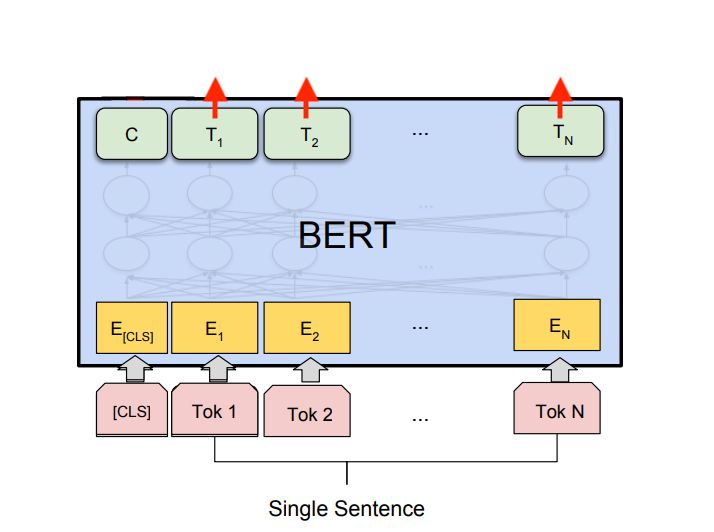

Since the dataset is labelled in a character-level fashion (having spans classified), in order to perform token-level classification, we associated to each token embedding the union of all the techniques relative to the spans it belongs to.


**NOTE:** Since we pad until max length, we "mark" the tokens corresponding to the padding with a dummy entry equal to -100.

In [ ]:
pretrained_transformer_name='bert-base-cased'

In [ ]:
gc.collect()

##Dataset

The train, dev and test datasets contain 688, 63 and 200 memes respectively.

The distribution of samples among the classes is highly unbalanced, as it is shown in the following plot.

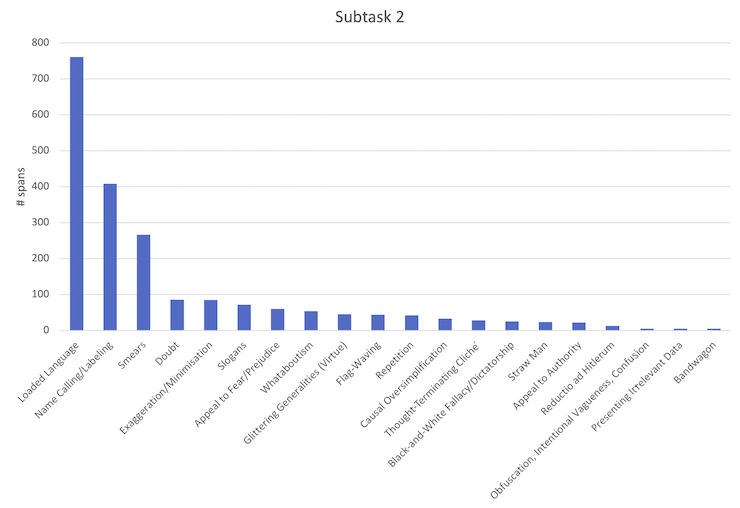

In [ ]:
dataset_folder=folder_name+"/Dataset/data/"
train_st2 = dataset_folder+"training_set_task2.txt"
dev_st2 = dataset_folder+"dev_set_task2.txt"
test_st2 = dataset_folder+"test_set_task2.txt"

In [ ]:
train_data2 = pd.read_json(train_st2)
dev_data2 = pd.read_json(dev_st2)
test_data2 = pd.read_json(test_st2)

In [ ]:
train_data2

In [ ]:
techniques = [['Appeal to authority', 'Appeal to fear/prejudice', 'Bandwagon',
               'Black-and-white Fallacy/Dictatorship',
               'Causal Oversimplification', 'Doubt', 'Exaggeration/Minimisation',
               'Flag-waving', 'Glittering generalities (Virtue)',
               'Loaded Language',
               "Misrepresentation of Someone's Position (Straw Man)",
               'Name calling/Labeling',
               'Obfuscation, Intentional vagueness, Confusion',
               'Presenting Irrelevant Data (Red Herring)', 'Reductio ad hitlerum',
               'Repetition', 'Slogans', 'Smears', 'Thought-terminating cliché',
               'Whataboutism']]

In [ ]:
class Task2Dataset(Dataset):
    def __init__(self, input_id, attention, token_ids, labels):
        self.attention = attention
        self.input_id = input_id
        self.token_ids = token_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        token_id = torch.Tensor(
            [-100 if(tok == None) else tok for tok in self.token_ids[idx]]).int()
        sample = {"attention_mask": attention, "input_ids": input_id,
                  "token_ids": token_id, "labels": label}
        return sample

##Random Baseline

In [ ]:
random.seed(42)

Random baseline predictions from SEMEVAL-2021-task6: [GitHub link](https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/blob/main/baselines/baseline_task2.py)

In [ ]:
def get_predictions(data):
    all_predictions = []
    for sample in data:
        start_fragment, end_fragment, text_length = (0, 0, len(sample))
        current_sample = []
        techniques_names = techniques[0][:]
        while end_fragment < text_length:
            if end_fragment > 0:
                random_technique = techniques_names[random.randint(
                    0, len(techniques_names)-1)]
                # check that there is no other annotation for the same article and technique that overlaps
                intersection_length = 0
                if len(current_sample) > 0:
                    span_annotation = set(range(start_fragment, end_fragment))
                    intersection_length = sum([len(span_annotation.intersection(set(range(start_fragment, end_fragment))))
                                              for previous_technique, start_fragment, end_fragment in current_sample if previous_technique == random_technique])
                if len(current_sample) == 0 or intersection_length == 0 or random.random() < 0.4:
                    current_sample.append(
                        (random_technique, start_fragment, end_fragment))
            start_fragment += random.randint(0,
                                             max(1, text_length-start_fragment))
            end_fragment = min(
                start_fragment + random.randint(1, text_length-start_fragment+1), text_length)
        prediction = [{"technique": l, "start": s, "end": e}
                      for l, s, e in current_sample]
        all_predictions.append(prediction)
    return all_predictions

The [official metrics](https://arxiv.org/pdf/2105.09284.pdf) of SemEval competition for this subtask are defined as it follows:


*   Precision: $P(S,T)=\frac{1}{|S|} \sum_{s \in S, t \in T} C(s,t,|s|)$
*   Recall: $R(S,T)=\frac{1}{|T|} \sum_{s \in S, t \in T} C(s,t,|t|)$

*   F1-score: $F1(P,R) = 2*\frac{P * R}{P + R} $

Where:
*   $S$ is the set of the predicted spans
*   $T$ is the set of true spans

*   $C(s,t,h) = \frac{| s ∩ t|}{h}\delta(l(s),l(t))$

*   $\delta(a,b) = 1$ if $a = b$, $0$ otherwise

*   $l(x)$ is the label of $x$













In [ ]:
def C(s_start,s_end,t_start,t_end,s_tech, t_tech, h):
  if (s_tech != t_tech or h==0):
    return 0
  span_s = set(range(s_start, s_end))
  span_t = set(range(t_start, t_end))
  common = len(span_s.intersection(span_t))
  return common/h

In [ ]:
def P(predictions, labels):
    S = 0
    count = 0
    for preds, labs in zip(predictions, labels):
        for s in preds:
            for t in labs:
                count += C(s["start"], s["end"], t["start"], t["end"],
                           s["technique"], t["technique"], s["end"]-s["start"])
        S += len(preds)
    if(S == 0):
        return 0
    else:
        return count/S

In [ ]:
def R(predictions, labels):
    T = 0
    count = 0
    for preds, labs in zip(predictions, labels):
        for s in preds:
            for t in labs:
                count += C(s["start"], s["end"], t["start"], t["end"],
                           s["technique"], t["technique"], t["end"]-t["start"])
        T += len(labs)
    if(T == 0):
        return 0
    else:
        return count/T

In [ ]:
def F1(precision,recall):
  return 2*(precision*recall) / (precision + recall)

In [ ]:
print("DEV RANDOM BASELINE SCORES: ")
dev_predictions = get_predictions(dev_data2.text.values)
labels = dev_data2.labels.values
precision = P(dev_predictions, labels)
print("Precision: {}".format(precision))
recall = R(dev_predictions, labels)
print("Recall: {}".format(recall))
print("F1-score: {}".format(F1(precision, recall)))

In [ ]:
print("TEST RANDOM BASELINE SCORES: ")
test_predictions = get_predictions(test_data2.text.values)
labels = test_data2.labels.values
precision = P(test_predictions, labels)
print("Precision: {}".format(precision))
recall = R(test_predictions, labels)
print("Recall: {}".format(recall))
print("F1-score: {}".format(F1(precision, recall)))

## Loss Function

We adjusted the BCE loss function in order not to consider the special tokens.

In [ ]:
class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
        self.loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, labels, token_mask):
        loss_tensor = self.loss(logits, labels)
        # [8,185,20]
        # loss_mask tensor([ True,  True,  True,  True,  True, False])
        loss_mask = token_mask != -100
        loss_sum = torch.sum(loss_tensor, dim=2)
        zero = torch.tensor(0.0, device=device)
        loss_masked = loss_sum.where(loss_mask, zero)
        num_classes = loss_tensor.size()[2]
        batch_size = loss_tensor.size()[0]

        reduced_loss = loss_masked.sum() / (batch_size*loss_mask.sum()*num_classes)

        return reduced_loss

In order to get over the dataset imbalance, we tried two different approaches.

A first approach consisted in a weighted version of Binary Cross Entropy which adds weights to positive samples in the loss function with the following formula (from [Volta at SemEval-2021 Task 6](https://arxiv.org/pdf/2106.00240.pdf)):

$l(x,y) = - \dfrac{1}{Nd}\sum_{n=1}^{N}\sum_{k=1}^{d}[p^k y_n^k \log(x_n^k) + (1 - y_n^k)\log(1-x_n^k)]$

where $p^k = \dfrac{1}{f^k}(|K| - f^k)$, $N$ is the batch size, $n$ is and index for the $n^{th}$ batch element, $d$ is the number of classes, $f$ stands for a vector of class absolute frequencies (note that the classes frequencies are not computed considering the spans, but considering the sentences.), $x$ is a vector from the last Sigmoid layer, $y$ is a vector representing the labels and $|K|$ is the size of the train set.

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedBCELoss, self).__init__()
        self.y_train = y_train
        self.pos_weight = self.weighted_factors()

    def forward(self, logits, labels, token_mask):
        loss = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight, reduction='none')
        loss_tensor = loss(logits, labels)
        # [8,185,20]
        # loss_mask tensor([ True,  True,  True,  True,  True, False])
        loss_mask = token_mask != -100
        loss_sum = torch.sum(loss_tensor, dim=2)
        zero = torch.tensor(0.0, device=device)
        loss_masked = loss_sum.where(loss_mask, zero)
        num_classes = loss_tensor.size()[2]
        batch_size = loss_tensor.size()[0]

        reduced_loss = loss_masked.sum() / (batch_size*loss_mask.sum()*num_classes)

        return reduced_loss

    def weighted_factors(self):
        ors = torch.Tensor([self.logical_or(sample)
                           for sample in self.y_train])
        f = torch.sum(ors, dim=0)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        pos_weight = torch.div(torch.sub(K, f), f).to(device=device)
        return pos_weight

    def logical_or(self, t):
        res = torch.clone(t[1])
        for x in t[2:]:
            if(x[0] == -100):  # we are not considering special tokens
                break
            res = torch.logical_or(res, x)
        return res.detach().numpy().astype(np.int)

As second approach we use [Focal loss](https://arxiv.org/pdf/1708.02002.pdf) which focuses on improving predictions on hard misclassified examples.

This is achieved by adding the two hyper-parameters to the cross entropy loss, $\alpha$ and $γ$, where $α$ controls the weight of positive and negative samples and $γ$ scales the loss of hard and easy samples.

So, for the $i^{th}$ class:
$L_{class_i}=\begin{cases}
α(1-p)^γ\log(p),& \text{if y=1} \\
(1-α)p^γ\log(1-p),& \text{otherwise}
\end{cases}
$, where $y$ is the ground truth and $p$ is the model's prediction.

In our experiments we noticed worse results for values of $α$ different from 1, so we deleted this parameter and kept just the focusing parameter $γ$.

Note that in both cases, during the loss computation we don't consider the special tokens.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, labels, token_mask):
        p = torch.sigmoid(logits)
        loss = self.loss(logits, labels)
        p_t = p*labels + (1. - p)*(1. - labels)
        loss_tensor = ((1-p_t)**self.gamma) * loss

        # [8,185,20]
        # loss_mask tensor([ True,  True,  True,  True,  True, False])
        loss_mask = token_mask != -100
        loss_sum = torch.sum(loss_tensor, dim=2)
        zero = torch.tensor(0.0, device=device)
        loss_masked = loss_sum.where(loss_mask, zero)
        num_classes = loss_tensor.size()[2]
        batch_size = loss_tensor.size()[0]

        reduced_loss = loss_masked.sum() / (batch_size*loss_mask.sum()*num_classes)

        return reduced_loss

##Lightning DataModule

In [ ]:
class Task2DataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        test_data,
        val_data,
        techniques,
        model_name: str = "bert-base-uncased",
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_labels = 20
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.mlb = MultiLabelBinarizer()

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.mlb.fit(self.techniques)
        y_train = self.train_data["labels"]

        self.X_test = self.test_data.text.values
        y_test = self.test_data["labels"]

        self.X_val = self.val_data.text.values
        y_val = self.val_data["labels"]

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention, self.X_train_token_ids = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention, self.X_val_token_ids = self.preprocessing(
            self.X_val)
        self.X_test_enc, self.X_test_attention, self.X_test_token_ids = self.preprocessing(
            self.X_test)

        self.y_train = self.preprocessing_labels(
            self.X_train_enc, self.X_train_token_ids, y_train)
        self.y_val = self.preprocessing_labels(
            self.X_val_enc, self.X_val_token_ids, y_val)
        self.y_test = self.preprocessing_labels(
            self.X_test_enc, self.X_test_token_ids, y_test)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = Task2Dataset(
            self.X_train_enc, self.X_train_attention, self.X_train_token_ids, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)

        return train_dataloader

    def val_dataloader(self):
        data = Task2Dataset(self.X_val_enc, self.X_val_attention,
                            self.X_val_token_ids, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def test_dataloader(self):
        data = Task2Dataset(self.X_test_enc, self.X_test_attention,
                            self.X_test_token_ids, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)

        return test_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []
        token_ids = []

        for sent in data:
            preprocessed_sent = sent.strip().split()
            encoded_sent = self.tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                is_split_into_words=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))
            token_ids.append(encoded_sent.word_ids())

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        return input_ids, attention_masks, token_ids

    def maxLen(self):
        tmp = np.concatenate([self.X_train, self.X_test])
        X_all = np.concatenate([tmp, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len

    def find_sequence(self, full_t, seq_t):
        len = seq_t.size()[0]
        len_t = full_t.size()[0]
        c = 0
        i = 0
        prec = -1
        while(c < len):
            if(i >= len_t):
                return -1, -1
            if(full_t[i] == seq_t[c]):
                prec = full_t[i]
                c = c+1
            elif(full_t[i] != prec or c != 1):
                i = i - c
                c = 0
            i = i+1
        return i-c, len

    def take_sub(self, seq_t):
        t = seq_t[seq_t.nonzero()].flatten()[1:-1].int()
        return t

    def preprocessing_labels(self, X_enc, X_tok, labels):
        y_train = []

        for idx, X in enumerate(X_enc):
            y_sample = [[0 for i in range(20)] for j in range(self.max_length)]

            for label in labels[idx]:
                text_fragment = label['text_fragment']
                tech = label['technique']

                text_enc = self.preprocessing([text_fragment])[0]

                seq = self.take_sub(text_enc[0])
                index, len_sequence = self.find_sequence(X, seq)

                token_label = self.mlb.transform([[tech]])[0]

                for i in range(len_sequence):
                    y_sample[index+i] = list(np.logical_or(
                        y_sample[index+i], token_label).astype(int))

            # -100 is used to mark special tokens (to be ignored)
            ignore = [-100 for i in range(20)]
            y_sample_masked = [ignore if X_tok[idx][i] ==
                               None else y_sample[i] for i in range(len(X_tok[0]))]

            y_train.append(y_sample_masked)

        Y_train = torch.Tensor(y_train).int()

        return Y_train

In [ ]:
dm = Task2DataModule(train_data2, test_data2, dev_data2, techniques=techniques,
                      model_name=pretrained_transformer_name, batch_size=8)
dm.setup()

## Subtask 2 Model

Definition of the callbacks for validation and testing called by the model to compute metrics.

The [official metrics](https://arxiv.org/pdf/2105.09284.pdf) of SemEval competition for this subtask are defined as it follows:


*   Precision: $P(S,T)=\frac{1}{|S|} \sum_{s \in S, t \in T} C(s,t,|s|)$
*   Recall: $R(S,T)=\frac{1}{|T|} \sum_{s \in S, t \in T} C(s,t,|t|)$

*   F1-score: $F1(P,R) = 2*\frac{P * R}{P + R} $

Where:
*   $S$ is the set of the predicted spans
*   $T$ is the set of true spans

*   $C(s,t,h) = \frac{| s ∩ t|}{h}\delta(l(s),l(t))$

*   $\delta(a,b) = 1$ if $a = b$, $0$ otherwise

*   $l(x)$ is the label of $x$

In the following evaluation callback these formulas are adjusted to be computed in a token-level fashion (instead that character-level).












In [ ]:
class Task2EvaluateCallback(Callback):
    def __init__(
        self,
        val_text,
        test_text
    ):
        super().__init__()
        self.val_text = [x.split() for x in val_text]
        self.test_text = [x.split() for x in test_text]

    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        classes = model.mlb.classes_
        predictions, labels = self.compute_predictions(
            model.predictions, model.labels, model.token_ids)


        print("\033[1m" +"Official Character-level metrics"+ "\033[0m")
        self.print_official_metrics(
            predictions, labels, self.val_text, model.num_classes)

        print("-"*100)

        print("Word-level metrics")
        self.print_token_metrics(
            predictions, labels, classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()
        model.token_ids = torch.Tensor()

        return

    def on_test_end(self, trainer, model):
        print("Test metrics:")
        classes = model.mlb.classes_
        predictions, labels = self.compute_predictions(
            model.predictions, model.labels, model.token_ids)

        print("\033[1m" + "Official Character-level metrics"+ "\033[0m")
        self.print_official_metrics(
            predictions, labels, self.test_text, model.num_classes)

        print("-"*100)

        print("Word-level metrics")
        self.print_token_metrics(
            predictions, labels, classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()
        model.token_ids = torch.Tensor()

        return

    def print_token_metrics(self, predictions, labels, classes, num_classes):
        all_toks_pred = []
        all_toks_lab = []
        for i in range(len(predictions)):
            for j in range(len(predictions[i])):
                all_toks_pred.append(predictions[i][j])
                all_toks_lab.append(labels[i][j])

        print("F1-micro: {}".format(f1_score(all_toks_lab,
              all_toks_pred, average="micro", zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_toks_lab,
              all_toks_pred, average="macro", zero_division=1)))

        print(classification_report(all_toks_lab, all_toks_pred,
              target_names=classes, zero_division=1))

        all_toks_pred = torch.Tensor(all_toks_pred).int()
        all_toks_lab = torch.Tensor(all_toks_lab).int()

        confMatrix = torchmetrics.ConfusionMatrix(
            num_classes=num_classes, multilabel=True)
        conf_mat = confMatrix(all_toks_pred, all_toks_lab)
        plot_confusion_multi(conf_mat, classes)
        return

    def print_official_metrics(self, predictions, labels, text, num_classes):
        p, r, f = self.metrics(predictions, labels, text, num_classes)
        print("Precision: {}\nRecall: {}\nF1: {}".format(p, r, f))
        return

    def sample_c(self, predictions, labels, values, num_classes):
        count_S = 0
        count_T = 0
        S = 0
        T = 0
        for idx in range(num_classes):
            c = 0
            t = 0
            s = 0
            # flags[0] -> c, flags[1] -> s, flags[2] -> t
            flags = [False, False, False]
            num_words = len(predictions)
            for i in range(num_words):
                p = predictions[i][idx]
                l = labels[i][idx]
                w = values[i]
                if(p == l and p == 1):
                    c += len(w)
                    s += len(w)
                    t += len(w)
                    if(flags[0] == False):
                        flags[0] = True
                    else:
                        c += 1
                    if(flags[1] == False):
                        S += 1
                        flags[1] = True
                    else:
                        s += 1
                    if(flags[2] == False):
                        T += 1
                        flags[2] = True
                    else:
                        t += 1
                elif(p != l and p == 1):
                    flags[2] = False
                    flags[0] = False
                    s += len(w)

                    if(t!=0):
                      count_T += c/t

                    j = i + 1
                    s_tot = s
                    while(j<num_words and labels[j][idx] != 0):
                      s_tot += len(values[j])+1
                      j += 1

                    if(s_tot!=0):
                      count_S += c/s_tot

                    c = 0
                    t = 0

                    if(flags[1] == False):
                        S += 1
                        flags[1] = True
                    else:
                        s += 1

                elif(p != l and l == 1):
                    flags[1] = False
                    flags[0] = False
                    t += len(w)

                    if(s!=0):
                      count_S += c/s

                    j = i + 1
                    t_tot = t
                    while(j<num_words and predictions[j][idx] != 0):
                      t_tot += len(values[j])+1
                      j += 1

                    if(t_tot!=0):
                      count_T += c/t_tot

                    c = 0
                    s = 0

                    if(flags[2] == False):
                        T += 1
                        flags[2] = True
                    else:
                        t += 1
                if((p == l and p == 0) or (i == num_words-1)):
                    if(s!=0):
                      count_S += c/s
                    if(t!=0):
                      count_T += c/t

                    c = 0
                    t = 0
                    s = 0
                    flags = [False, False, False]
        return count_S, count_T, S, T

    def metrics(self, predictions, labels, text, num_classes):
        count_S = 0
        count_T = 0
        S = 0
        T = 0
        precision = 0
        recall = 0
        f1 = 0
        for pred, lab, txt in zip(predictions, labels, text):
            values = self.sample_c(pred, lab, txt, num_classes)
            count_S += values[0]
            count_T += values[1]
            S += values[2]
            T += values[3]
        if (S != 0):
            precision = count_S / S
        if (T != 0):
            recall = count_T / T
        if(precision + recall != 0):
            f1 = 2*(precision*recall) / (precision + recall)
        return precision, recall, f1

    def compute_predictions(self, predictions, labels, token_ids):
        true_predictions = []
        true_labels = []
        for prediction, label, token_id in zip(predictions, labels, token_ids):
            tok_prec = -1
            pred = []
            lab = []
            for i in range(len(token_id)):
                if label[i][0] == -100:
                    continue
                if token_id[i] == tok_prec:
                    pred[-1] = [int(pred[-1][j] or prediction[i][j])
                                for j in range(len(prediction[i]))]
                else:
                    tok_prec = token_id[i]
                    pred.append(prediction[i].tolist())
                    lab.append(label[i].tolist())
            true_predictions.append(pred)
            true_labels.append(lab)
        return true_predictions, true_labels

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class Task2Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 20,
        model_name_or_path: str = "bert-base-uncased",
        learning_rate: float = 1e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        #self.loss = BCELoss()
        #self.loss = WeightedBCELoss(y_train)
        self.loss = FocalLoss()
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())
        self.register_buffer("token_ids", torch.Tensor())

        self.cm = torchmetrics.ConfusionMatrix(
            num_classes=self.num_classes, multilabel=True)

        D_in, H, D_out = 768, 64, self.num_classes
        loaded_model = PTCTransformer.load_from_checkpoint(
            checkpoint_path=PTC_checkpoints+"PTC_"+model_name_or_path+"_FL.ckpt")
        self.transformer = loaded_model
        self.transformer.extractor = Identity()
        self.transformer.classifier = Identity()

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        plm_output = self.transformer(**inputs)
        hidden_states = plm_output[0][:, :, :]
        logits = self.classifier(hidden_states)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        token_mask = batch["token_ids"]
        loss = self.loss(logits, labels.to(torch.float32), token_mask)
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch["labels"]
        logits = self(**batch)
        token_mask = batch["token_ids"]
        val_loss = self.loss(logits, labels.to(torch.float32), token_mask)
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        return {"loss": val_loss, "predictions": predictions,
                "labels": labels, "token_mask": token_mask}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

            token_masks = [x["token_mask"] for x in outputs]
            self.token_ids = torch.cat(token_masks, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch["labels"]
        logits = self(**batch)
        token_mask = batch["token_ids"]
        test_loss = self.loss(logits, labels.to(torch.float32), token_mask)

        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)
        self.token_ids = torch.cat((self.token_ids, token_mask), 0)

        return {"loss": test_loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        token_mask = batch["token_ids"]
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        predictions = self.compute_predictions(predictions, token_mask)

        predicted_techs = []
        for sample in predictions:
            predicted_sent = []
            for word in sample:
                tech = self.mlb.inverse_transform(np.array([word]))
                predicted_sent.append(tech)
            predicted_techs.append(predicted_sent)

        return predictions

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        return [optimizer]

    def compute_predictions(self, predictions, token_ids):
        true_predictions = []
        for prediction, token_id in zip(predictions, token_ids):
            tok_prec = -1
            pred = []
            for i in range(len(token_id)):
                if token_id[i] == -100:
                    continue
                if token_id[i] == tok_prec:
                    pred[-1] = [int(pred[-1][j] or prediction[i][j])
                                for j in range(len(prediction[i]))]
                else:
                    tok_prec = token_id[i]
                    pred.append(prediction[i].tolist())
            true_predictions.append(pred)
        return true_predictions



## Train and Validation

In [ ]:
model = Task2Model(dm.mlb, dm.y_train,
                         model_name_or_path=pretrained_transformer_name)

In [ ]:
log_dir = logs_dir+"SubTask2/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask2_net", version="TEST", log_graph=True)

In [ ]:
val_text = dm.X_val
test_text = dm.X_test

In [ ]:
trainer = Trainer(max_epochs=12, gpus=AVAIL_GPUS, logger=logger, callbacks=[
                  Task2EvaluateCallback(val_text, test_text)])

In [ ]:
trainer.fit(model, dm)

## Testing

In [ ]:
trainer.test(model,dm)

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/DeepProject/Logs/SubTask2/

## Example prediction


In [ ]:
def postprocessing(predictions, batch_size, data):
    all_dicts = []
    for b, batch_preds in enumerate(predictions):
        for i in range(batch_size):
            sample_dict = {}
            text = data[batch_size*b+i].strip()
            sample_dict["text"] = text
            sample_dict["labels"] = []
            tokens = text.split()
            preds = batch_preds[i]

            for idx in range(20):
                dict_span = {}
                dict_span["technique"] = techniques[0][idx]
                dict_span["start"] = 0
                dict_span["end"] = 0
                dict_span["text_fragment"] = ""
                prec = False
                current = 0
                for j, word in enumerate(tokens):
                    if preds[j][idx] == 1:
                        if prec:
                            dict_span["end"] = dict_span["end"] + len(word) + 1
                            current = dict_span["end"] + 1
                            dict_span["text_fragment"] = dict_span["text_fragment"] + " " + word
                        else:
                            prec = True
                            dict_span["start"] = current
                            dict_span["end"] = current + len(word)
                            dict_span["text_fragment"] = word
                            current = dict_span["end"] + 1
                    else:
                        if prec:
                            current = current + len(word) + 1
                            sample_dict["labels"].append(dict_span)
                            dict_span = {}
                            dict_span["technique"] = techniques[0][idx]
                            prec = False
                        else:
                            current = current + len(word) + 1

            all_dicts.append(sample_dict)
    return all_dicts

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
dict_predictions = postprocessing(
    predictions, batch_size=8, data=test_data2.text.values)

In [ ]:
print("\033[1m" + "Five examples of predictions:" + "\033[0m")
for i in range(8):
    text = dict_predictions[i]["text"].replace(
        '\\', "").replace('\n', ' ').strip()
    print("Text: '{}'".format(text))
    preds = dict_predictions[i]["labels"]
    print("Predicted spans: {}".format(preds))
    labels = test_data2.labels.values[i]
    print("Correct spans: {}".format(labels))
    print("-"*180)

## Final Results

During all the performed experiments we used the following parameters:

| Parameters (TASK 2) |          |
|:-------------------:|:--------:|
|       Dropout       |   0.25   |
|      Batch Size     |     8    |
|    Learning Rate    | 1,00E-05 |
|      Optimizer      |   AdamW  |
|     Adam Epsilon    | 1,00E-08 |
|     Weight Decay    |    0.1   |
|        Epochs       |    12    |

We obtained the following results:

|  Model (TASK 2) |       Loss      |  DEV-SET  | DEV-SET | DEV-SET |  TEST-SET | TEST-SET | TEST-SET |
|:---------------:|:---------------:|:---------:|:-------:|:-------:|:---------:|:--------:|:--------:|
|                 |                 | Precision |  Recall |    F1   | Precision |  Recall  |    F1    |
|       BERT      |     BCELoss     |    0.39   |   0.01  |   0.03  |    0.32   |   0.01   |   0.03   |
|       BERT      | WeightedBCELoss |    0.14   |   0.10  |   0.12  |    0.14   |   0.11   |   0.13   |
|       BERT      |    FocalLoss    |    0.60   |   0.12  |   0.19  |    0.42   |   0.10   |   0.16   |
|                 |                 |           |         |         |           |          |          |
| Random Baseline |                 |    0.05   |   0.02  |   0.03  |    0.04   |   0.02   |   0.02   |

Eventually, the model in which we use Focal Loss as loss function reaches better results w.r.t. the others.

# Subtask 3
Given a meme, identify all techniques used in the meme, including the text and the visual content (multimodal task). This is a multilabel classification problem.

Our approach in SubTask3 takes into consideration different model architectures:


*   Uni-modal techniques:
  *   DeBERTa + Resnet50 embeddings
  *   DeBERTa + FasterRCNN embeddings


*   MMBT: MultiModal BiTransformers



*   Visual-Bert:
  *   with Resnet50 embeddings
  *   with FasterRCNN embeddings


*   DVTT: Double Visual Textual Transformer


The first approach is inspired by group Alpha at SemEval-2021, described in [this article](https://aclanthology.org/2021.semeval-1.8/), Alpha ranked 1st at this subtask in the competition.

DVTT is the approach used by group AIMH at SemEval-2021 described in [this article](https://aclanthology.org/2021.semeval-1.140/), AIMH ranked 4th at this subtask in the competition.


**Note:**
It is not possible to run the whole set of experiments all at once in the colab notebook (due to the GPU and RAM limits of Colab).
Each experiment can run alone but there's no guarantee that colab allows to run to experimens one after another without Restarting the Runtime connection.


In [ ]:
gc.collect()

## Data Folders

The train, dev and test datasets contain 687, 63 and 200 memes respectively.

The distribution of samples among the classes is highly unbalanced, as it is shown in the following plot.

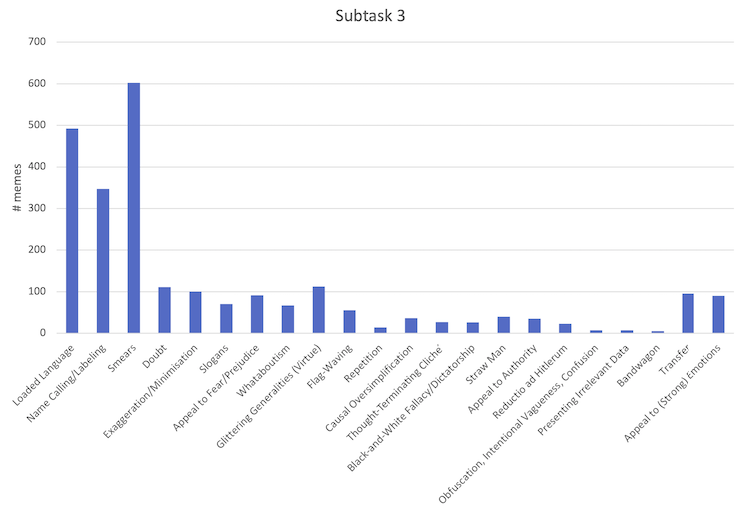

In [ ]:
dataset_folder = folder_name+"Dataset/data/"
train_st3_dir = dataset_folder+"training_set_task3/"
dev_st3_dir = dataset_folder+"dev_set_task3_labeled/"
test_st3_dir = dataset_folder+"test_set_task3/"

In [ ]:
train_text3 = train_st3_dir+"training_set_task3.txt"
dev_text3 = dev_st3_dir+"dev_set_task3_labeled.txt"
test_text3 = test_st3_dir+"test_set_task3.txt"

In [ ]:
train_data3 = pd.read_json(train_text3)
dev_data3 = pd.read_json(dev_text3)
test_data3 = pd.read_json(test_text3)

In [ ]:
train_data3

In [ ]:
techniques = [['Appeal to (Strong) Emotions', 'Appeal to authority',
               'Appeal to fear/prejudice', 'Bandwagon',
               'Black-and-white Fallacy/Dictatorship',
               'Causal Oversimplification', 'Doubt', 'Exaggeration/Minimisation',
               'Flag-waving', 'Glittering generalities (Virtue)',
               'Loaded Language',
               "Misrepresentation of Someone's Position (Straw Man)",
               'Name calling/Labeling',
               'Obfuscation, Intentional vagueness, Confusion',
               'Presenting Irrelevant Data (Red Herring)', 'Reductio ad hitlerum',
               'Repetition', 'Slogans', 'Smears', 'Thought-terminating cliché',
               'Transfer', 'Whataboutism']]

##Loss Functions

A first approach consisted in a weighted version of Binary Cross Entropy which adds weights to positive samples in the loss function with the following formula (from [Volta at SemEval-2021 Task 6](https://arxiv.org/pdf/2106.00240.pdf)):

$l(x,y) = - \dfrac{1}{Nd}\sum_{n=1}^{N}\sum_{k=1}^{d}[p^k y_n^k \log(x_n^k) + (1 - y_n^k)\log(1-x_n^k)]$

where $p^k = \dfrac{1}{f^k}(|K| - f^k)$, $N$ is the batch size, $n$ is and index for the $n^{th}$ batch element, $d$ is the number of classes, $f$ stands for a vector of class absolute frequencies, $x$ is a vector from the last Sigmoid layer, y is a vector representing the labels and $|K|$ is the size of the train set.

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedBCELoss, self).__init__()
        self.y_train = y_train
        pos_weight = self.weighted_factors()
        self.BCE = torch.nn.BCEWithLogitsLoss(
            pos_weight=pos_weight, reduction='mean')

    def forward(self, logits, labels):
        return self.BCE(logits, labels)

    def weighted_factors(self):
        f = torch.sum(self.y_train, dim=0)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        pos_weight = torch.div(torch.sub(K, f), f).to(device=device)
        return pos_weight

As second approach we use [Focal loss](https://arxiv.org/pdf/1708.02002.pdf) which focuses on improving predictions on hard misclassified examples.

This is achieved by adding the two hyper-parameters to the cross entropy loss, $\alpha$ and $γ$, where $α$ controls the weight of positive and negative samples and $γ$ scales the loss of hard and easy samples.

So, for the $i^{th}$ class:
$L_{class_i}=\begin{cases}
α(1-p)^γ\log(p),& \text{if y=1} \\
(1-α)p^γ\log(1-p),& \text{otherwise}
\end{cases}
$, where $y$ is the ground truth and $p$ is the model's prediction.

In our experiments we noticed worse results for values of $α$ different from 1, so we deleted this parameter and kept just the focusing parameter $γ$.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, labels):
        p = torch.sigmoid(logits)
        loss = self.loss(logits, labels)
        p_t = p*labels + (1. - p)*(1. - labels)
        loss_tensor = ((1-p_t)**self.gamma) * loss
        return torch.mean(loss_tensor)

## Evaluate Callback

Definition of the callbacks for validation and testing called by all the models to compute metrics

In [ ]:
class Task3EvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def on_test_end(self, trainer, model):
        print("Test metrics:")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def print_evaluation(self, all_predictions, all_labels, classes, num_classes):
        all_predictions = all_predictions.detach().cpu()
        all_labels = all_labels.detach().cpu()

        confMatrix = torchmetrics.ConfusionMatrix(
            num_classes=num_classes, multilabel=True)
        conf_mat = confMatrix(all_predictions, all_labels)
        plot_confusion_multi(conf_mat, classes)

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average="micro", zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average="macro", zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(num_classes)], target_names=classes, zero_division=1))

        return

##Random Baseline

random baseline from SEMEVAL-2021-task6: [GitHub link](https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus/blob/main/baselines/baseline_task3_random.py)

In [ ]:
random.seed(42)

In [ ]:
def get_predictions(data):
    all_predictions = []
    for sample in data:
        prediction = []
        i = 0
        techniques_names = techniques[0][:]
        while i < len(techniques_names) and random.random() < 0.5:
            random_technique = techniques_names[random.randint(
                0, len(techniques_names)-1)]
            prediction.append(random_technique)
            techniques_names.remove(random_technique)
            i += 1
        all_predictions.append(prediction)
    return all_predictions

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(techniques)

In [ ]:
print("DEV RANDOM BASELINE SCORES: ")
dev_predictions = get_predictions(dev_data3.text.values)
preds = mlb.transform(dev_predictions)
labels = mlb.transform(dev_data3.labels.values)
print("F1-micro: {}".format(f1_score(labels, preds, average="micro", zero_division=1)))
print("F1-macro: {}".format(f1_score(labels, preds, average="macro", zero_division=1)))

In [ ]:
print("DEV RANDOM BASELINE SCORES: ")
test_predictions = get_predictions(test_data3.text.values)
preds = mlb.transform(test_predictions)
labels = mlb.transform(test_data3.labels.values)
print("F1-micro: {}".format(f1_score(labels, preds, average="micro", zero_division=1)))
print("F1-macro: {}".format(f1_score(labels, preds, average="macro", zero_division=1)))

## Dataset and DataModule

The classes defining the Dataset and the Datamodule are the same for all the models but MMBT that needs a different structure.

**DATASET**

In [ ]:
class Task3Dataset(Dataset):
    def __init__(self, input_id, token_type_ids, attention, images, labels):
        self.input_id = input_id
        self.token_type_ids = token_type_ids
        self.attention = attention

        self.images = images

        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_id = self.input_id[idx]
        token_type_ids = self.token_type_ids[idx]
        attention = self.attention[idx]

        image = self.images[idx]

        label = self.labels[idx]

        sample = {"input_ids": input_id, "token_type_ids": token_type_ids,
                  "attention_mask": attention, "images": image, "labels": label}
        return sample

**LIGHTINING DATA-MODULE**

In [ ]:
class Task3DataModule(LightningDataModule):
    def __init__(
        self,
        train_directory,
        train_data,
        test_directory,
        test_data,
        val_directory,
        val_data,
        techniques,
        num_classes: int = 22,
        model_name: str = "bert-base-cased",
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()
        self.train_directory = train_directory
        self.train_data = train_data

        self.test_directory = test_directory
        self.test_data = test_data

        self.val_directory = val_directory
        self.val_data = val_data

        self.techniques = techniques

        self.batch_size = batch_size
        self.num_classes = num_classes

        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.mlb = MultiLabelBinarizer()

        self.transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225])
        ])

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.mlb.fit(self.techniques)
        y_train = self.mlb.transform(self.train_data.labels.values)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_val = self.val_data.text.values
        y_val = self.mlb.transform(self.val_data.labels.values)

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention, self.X_train_token_type_ids = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention, self.X_val_token_type_ids = self.preprocessing(
            self.X_val)
        self.X_test_enc, self.X_test_attention, self.X_test_token_type_ids = self.preprocessing(
            self.X_test)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)
        self.y_test = torch.tensor(y_test)

        train_images_path = self.train_data.image.values
        test_images_path = self.test_data.image.values
        val_images_path = self.val_data.image.values

        self.X_train_images = self.preprocessImages(
            self.train_directory, train_images_path)
        self.X_test_images = self.preprocessImages(
            self.test_directory, test_images_path)
        self.X_val_images = self.preprocessImages(
            self.val_directory, val_images_path)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = Task3Dataset(self.X_train_enc, self.X_train_token_type_ids,
                            self.X_train_attention,
                            self.X_train_images, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = Task3Dataset(self.X_val_enc, self.X_val_token_type_ids,
                            self.X_val_attention,
                            self.X_val_images, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def test_dataloader(self):
        data = Task3Dataset(self.X_test_enc, self.X_test_token_type_ids,
                            self.X_test_attention,
                            self.X_test_images, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []
        token_type_ids = []

        for sent in data:
            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = self.tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))
            token_type_ids.append(encoded_sent.get('token_type_ids'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        token_type_ids = torch.tensor(token_type_ids)
        return input_ids, attention_masks, token_type_ids

    def maxLen(self):
        tmp = np.concatenate([self.X_train, self.X_test])
        X_all = np.concatenate([tmp, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len

    def preprocessImages(self, dirPath, imagePathList):
        images = []

        for path in imagePathList:
            image_pil = Image.open(dirPath+path)
            image = self.transforms(image_pil)

            image_pil.close()

            images.append(image)

        images = torch.stack(images)
        return images

## DeBERTa + ResNet50 Embeddings

This approach considers the text and the image separately:
- the textual embedding is obtained with DeBERTa transformer
- the visual embedding is obtained from the features extracted by ResNet50

The features of the image are appended to the textual ones and the whole embedding is fed to DeBERTa transformer.
The classification is then obtained with two linear layers.

The visual features are extracted from the image with ResNet.

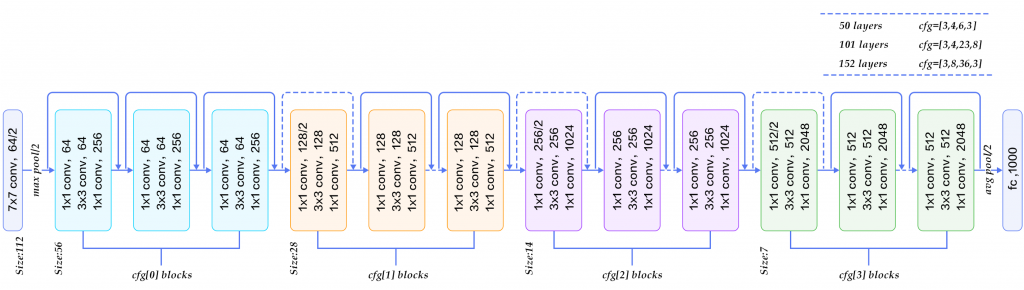

Features are extracted before the last pooling layer, we performed average pooling obtaining 10 different embeddings that are then passed into a linear layer to let them have 768 as dimension (to be coherent with the text token embeddings).

In [ ]:
text_transformer_name = "microsoft/deberta-base"
#text_transformer_name = "microsoft/deberta-v3-small"

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### Lightning DataModule

In [ ]:
dm = Task3DataModule(train_st3_dir, train_data3, test_st3_dir, test_data3,
                      dev_st3_dir, dev_data3, techniques=techniques,
                      model_name=text_transformer_name, batch_size=8)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d((10,1))
        self.linear = nn.Linear(2048,768)

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        out = self.linear(out)
        return out

In [ ]:
class FusionEmbeddings(nn.Module):
    def __init__(self, model_name, text_max_len):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = AutoModel.from_pretrained(model_name)
        self.text_max_len = text_max_len

        self.image_encoder.eval()
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_encoder.eval()
        for param in self.text_encoder.parameters():
            param.requires_grad = False

    def forward(self, **inputs):
        text_embeddings = self.text_encoder(input_ids=inputs["input_ids"],
                                            attention_mask=inputs["attention_mask"],
                                            token_type_ids=inputs["token_type_ids"]).last_hidden_state
        text_attention_masks = inputs["attention_mask"]
        text_token_type_ids_s = inputs["token_type_ids"]

        image_embeddings = self.image_encoder(inputs["images"])
        visual_token_type_ids_s = torch.ones(
            image_embeddings.shape[:-1], dtype=torch.long, device=device)
        visual_attention_masks = torch.ones(
            image_embeddings.shape[:-1], dtype=torch.float, device=device)

        im_emb_len = image_embeddings.size()[1]

        embedding_list = torch.Tensor().to(device)
        attention_masks = torch.Tensor().to(device)
        token_ids = torch.Tensor().to(device)

        max_len = self.text_max_len + im_emb_len

        for idx in range(len(text_embeddings)):

            t = text_embeddings[idx].tolist()
            im = image_embeddings[idx].tolist()

            visual_attention_mask = visual_attention_masks[idx].tolist()
            visual_token_type_ids = visual_token_type_ids_s[idx].tolist()
            text_attention_mask = text_attention_masks[idx].tolist()
            text_token_type_ids = text_token_type_ids_s[idx].tolist()

            txt_emb_len = len(t)
            padding_len = max_len - im_emb_len - txt_emb_len - 1

            padding = [[0]*768]*padding_len
            attention_padding = [0]*padding_len

            sep_emb = [t[-1]]
            sample_embedding = t + im + sep_emb + padding
            sample_attention_mask = text_attention_mask + \
                visual_attention_mask + [1] + attention_padding
            sample_token_ids = text_token_type_ids + \
                visual_token_type_ids + [1] + [1]*padding_len

            s_embedding = torch.unsqueeze(
                torch.Tensor(sample_embedding), 0).to(device)
            s_attention_mask = torch.unsqueeze(
                torch.Tensor(sample_attention_mask), 0).to(device)
            s_token_ids = torch.unsqueeze(
                torch.Tensor(sample_token_ids), 0).to(device)

            embedding_list = torch.cat((embedding_list, s_embedding), dim=0)
            attention_masks = torch.cat(
                (attention_masks, s_attention_mask), dim=0)
            token_ids = torch.cat((token_ids, s_token_ids), dim=0)

        return embedding_list, attention_masks, token_ids

In [ ]:
class Task3_DB_RN_Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        text_max_len,
        num_classes: int = 22,
        model_name: str = "microsoft/deberta-base",
        learning_rate: float = 3e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb
        self.text_max_len = text_max_len

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        self.loss = FocalLoss()
        #self.loss = torch.nn.BCEWithLogitsLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        self.fusion_encoder = FusionEmbeddings(model_name, self.text_max_len)

        self.fusion_encoder.eval()

        for param in self.fusion_encoder.parameters():
            param.requires_grad = False

        D_in, H, D_out = 768, 64, self.num_classes
        self.transformer = AutoModel.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        embedding_list, attention_masks, token_ids = self.fusion_encoder(
            **inputs)

        outputs = self.transformer(inputs_embeds=embedding_list, attention_mask=attention_masks,
                                   token_type_ids=token_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        #optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer

### Train and Validation

In [ ]:
model = Task3_DB_RN_Model(dm.mlb, dm.y_train,
                          dm.max_length, model_name=text_transformer_name)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_DB_ResNET", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## DeBERTa + FasterRCNN Embeddings

This approach considers the text and the image separately:
- the textual embedding is obtained with DeBERTa transformer
- the visual embedding is obtained from the features extracted by FasterRCNN

The features of the image are appended to the textual ones and the whole embedding is fed to DeBERTa transformer. The classification is then obtained with two linear layers.

The visual features are extracted from the image with [FasterRCNN](https://arxiv.org/pdf/1506.01497.pdf).

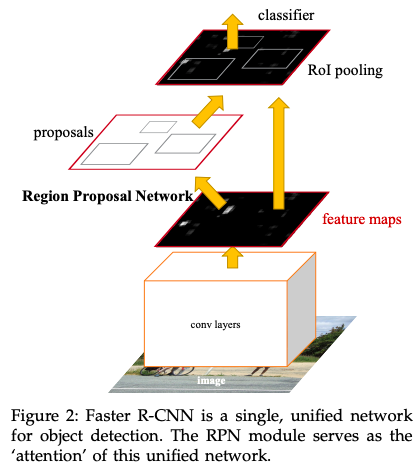

In this structure the RPN module generates region proposals applying attention mechanism to decide "where to look" for detecting objects in the image.
ROI Pooling layer extracts a fixed-length feature vector for each region proposal and these vetors are then classified with scores and are returned by the model together with the respective bounding-boxes.

We used ResNet50 as backbone network and extracted the features from ROI heads: after the region proposal network and before the classification layers of FasterRCNN.


In [ ]:
text_transformer_name = "microsoft/deberta-base"
#text_transformer_name = "microsoft/deberta-v3-small"

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### Lightning DataModule

In [ ]:
dm = Task3DataModule(train_st3_dir, train_data3, test_st3_dir, test_data3,
                      dev_st3_dir, dev_data3, techniques=techniques,
                      model_name=text_transformer_name, batch_size=8)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = detection.fasterrcnn_resnet50_fpn(
            pretrained=True, progress=True, pretrained_backbone=True, rpn_post_nms_top_n_test=10)
        self.linear = nn.Linear(1024, 768)

        self.features = torch.Tensor()
        # you can also hook layers inside the roi_heads
        layer_to_hook = 'roi_heads.box_head.fc7'
        for name, layer in self.model.named_modules():
            if name == layer_to_hook:
                layer.register_forward_hook(self.save_features)

    def save_features(self, mod, inp, outp):
        self.features = outp.unsqueeze(-1).view(-1, 10, 1024)

    def get_roi_features(self):
        return self.features

    def forward(self, x):
        self.model.eval()
        self.model(x)
        features = self.features
        out = self.linear(features)
        self.features = torch.Tensor()
        return out

In [ ]:
class FusionEmbeddings(nn.Module):
    def __init__(self, model_name, text_max_len):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = AutoModel.from_pretrained(model_name)
        self.text_max_len = text_max_len

        self.image_encoder.eval()
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_encoder.eval()
        for param in self.text_encoder.parameters():
            param.requires_grad = False

    def forward(self, **inputs):
        # content of inputs: input_ids, attention_mask, token_type_ids, images
        text_embeddings = self.text_encoder(input_ids=inputs["input_ids"],
                                            attention_mask=inputs["attention_mask"],
                                            token_type_ids=inputs["token_type_ids"]).last_hidden_state
        text_attention_masks = inputs["attention_mask"]
        text_token_type_ids_s = inputs["token_type_ids"]

        image_embeddings = self.image_encoder(inputs["images"])
        visual_token_type_ids_s = torch.ones(
            image_embeddings.shape[:-1], dtype=torch.long, device=device)
        visual_attention_masks = torch.ones(
            image_embeddings.shape[:-1], dtype=torch.float, device=device)

        im_emb_len = image_embeddings.size()[1]

        embedding_list = torch.Tensor().to(device)
        attention_masks = torch.Tensor().to(device)
        token_ids = torch.Tensor().to(device)

        max_len = self.text_max_len + im_emb_len

        for idx in range(len(text_embeddings)):

            t = text_embeddings[idx].tolist()
            im = image_embeddings[idx].tolist()

            visual_attention_mask = visual_attention_masks[idx].tolist()
            visual_token_type_ids = visual_token_type_ids_s[idx].tolist()
            text_attention_mask = text_attention_masks[idx].tolist()
            text_token_type_ids = text_token_type_ids_s[idx].tolist()

            txt_emb_len = len(t)
            padding_len = max_len - im_emb_len - txt_emb_len - 1

            padding = [[0]*768]*padding_len
            attention_padding = [0]*padding_len

            sep_emb = [t[-1]]
            sample_embedding = t + im + sep_emb + padding
            sample_attention_mask = text_attention_mask + \
                visual_attention_mask + [1] + attention_padding
            sample_token_ids = text_token_type_ids + \
                visual_token_type_ids + [1] + [1]*padding_len

            s_embedding = torch.unsqueeze(
                torch.Tensor(sample_embedding), 0).to(device)
            s_attention_mask = torch.unsqueeze(
                torch.Tensor(sample_attention_mask), 0).to(device)
            s_token_ids = torch.unsqueeze(
                torch.Tensor(sample_token_ids), 0).to(device)

            embedding_list = torch.cat((embedding_list, s_embedding), dim=0)
            attention_masks = torch.cat(
                (attention_masks, s_attention_mask), dim=0)
            token_ids = torch.cat((token_ids, s_token_ids), dim=0)

        return embedding_list, attention_masks, token_ids

In [ ]:
class Task3_DB_FR_Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        text_max_len,
        num_classes: int = 22,
        model_name: str = "microsoft/deberta-base",
        learning_rate: float = 3e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb
        self.text_max_len = text_max_len

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        #self.loss = FocalLoss()
        self.loss = torch.nn.BCEWithLogitsLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        self.fusion_encoder = FusionEmbeddings(model_name, self.text_max_len)

        self.fusion_encoder.eval()
        for param in self.fusion_encoder.parameters():
            param.requires_grad = False

        D_in, H, D_out = 768, 64, self.num_classes
        self.transformer = AutoModel.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        embedding_list, attention_masks, token_ids = self.fusion_encoder(
            **inputs)

        outputs = self.transformer(inputs_embeds=embedding_list, attention_mask=attention_masks,
                                   token_type_ids=token_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc, "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        #optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


### Train and Validation

In [ ]:
model = Task3_DB_FR_Model(dm.mlb, dm.y_train,
                          dm.max_length, model_name=text_transformer_name)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_DB_fasterRCNN_NET", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## MMBT

[Supervised Multimodal BiTransformers](https://arxiv.org/abs/1909.02950) is a BERT-like architectures that is based on unimodally pretrained text transformers and image encoders that are then finetuned in a joint modality projecting onto the text token space the visual embeddings.

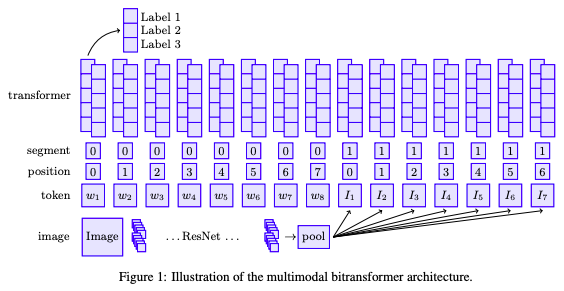

The weights to project the image embeddings to the token embedding space are learned starting from randomly initialized mappings.

During fine-tuning different components are freezed and unfreezed at different stages:
- the randomly initialized components can be trained first: the pre-trained unimodal models are initially freezed, to help learning to map image embeddings.
- Then the image encoder in unfreezed and trained first (otherwise the text modality would probably dominate)
- At the end the entire system is finetuned


### Dataset

In [ ]:
class Task3Dataset_MMBT(Dataset):
    def __init__(self, sentence, sent_attention_mask, image, start_token,
                 end_token, labels):
        self.sentence = sentence
        self.sent_attention_mask = sent_attention_mask
        self.image = image
        self.start_token = start_token
        self.end_token = end_token
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        sent_attention_mask = self.sent_attention_mask[idx]
        image = self.image[idx]
        start_token = self.start_token
        end_token = self.end_token
        labels = self.labels[idx]
        sample = {
            "input_ids": sentence,
            "attention_mask": sent_attention_mask,
            "input_modal": image,
            "modal_start_tokens": start_token,
            "modal_end_tokens": end_token,
            "labels": labels
            }
        return sample

In [ ]:
mmbt_pretrained_transformer_name = "bert-base-cased"

### Lightning DataModule

In [ ]:
class Task3DataModule_MMBT(LightningDataModule):
    def __init__(
        self,
        train_directory,
        train_data,
        test_directory,
        test_data,
        val_directory,
        val_data,
        techniques,
        num_classes: int = 22,
        model_name: str = "bert-base-uncased",
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()
        self.train_directory = train_directory
        self.train_data = train_data

        self.test_directory = test_directory
        self.test_data = test_data

        self.val_directory = val_directory
        self.val_data = val_data

        self.techniques = techniques

        self.batch_size = batch_size
        self.num_classes = num_classes

        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.mlb = MultiLabelBinarizer()

        self.transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225])
        ])

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.mlb.fit(self.techniques)
        y_train = self.mlb.transform(self.train_data.labels.values)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_val = self.val_data.text.values
        y_val = self.mlb.transform(self.val_data.labels.values)

        self.max_length = self.maxLen()

        self.start_token, self.end_token = self.getSpecialTokens()

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(self.X_val)
        self.X_test_enc, self.X_test_attention = self.preprocessing(
            self.X_test)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)
        self.y_test = torch.tensor(y_test)

        train_images_path = self.train_data.image.values
        test_images_path = self.test_data.image.values
        val_images_path = self.val_data.image.values

        self.X_train_images = self.preprocessImages(
            self.train_directory, train_images_path)
        self.X_test_images = self.preprocessImages(
            self.test_directory, test_images_path)
        self.X_val_images = self.preprocessImages(
            self.val_directory, val_images_path)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = Task3Dataset_MMBT(self.X_train_enc, self.X_train_attention,
                                 self.X_train_images, self.start_token,
                                 self.end_token, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = Task3Dataset_MMBT(self.X_val_enc, self.X_val_attention,
                                 self.X_val_images, self.start_token,
                                 self.end_token, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def test_dataloader(self):
        data = Task3Dataset_MMBT(self.X_test_enc, self.X_test_attention,
                                 self.X_test_images, self.start_token,
                                 self.end_token, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            sentence = [0] * self.max_length
            attention_mask = [0] * self.max_length

            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = self.tokenizer.encode(
                text=preprocessed_sent,
                add_special_tokens=False
            )

            length = len(encoded_sent)

            sentence[:length] = encoded_sent
            attention_mask[:length] = [1] * length

            input_ids.append(sentence)
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        return input_ids, attention_masks

    def getSpecialTokens(self):
        sent = "dummy"
        encoded_sent = self.tokenizer.encode(
            text=sent,
            add_special_tokens=True
        )
        start_token = encoded_sent[0]
        end_token = encoded_sent[-1]
        return start_token, end_token

    def maxLen(self):
        tmp = np.concatenate([self.X_train, self.X_test])
        X_all = np.concatenate([tmp, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len

    def preprocessImages(self, dirPath, imagePathList):
        images = []

        for path in imagePathList:
            image = Image.open(dirPath+path)
            image = self.transforms(image)

            images.append(image)

        images = torch.stack(images)
        return images


In [ ]:
dm = Task3DataModule_MMBT(
    train_st3_dir, train_data3,
    test_st3_dir, test_data3,
    dev_st3_dir, dev_data3,
    techniques=techniques,
    model_name=mmbt_pretrained_transformer_name,
    batch_size=8
)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(2)

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out

In [ ]:
class Task3Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 22,
        model_name_or_path: str = "bert-base-uncased",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        transformer_config = AutoConfig.from_pretrained(model_name_or_path)
        self.transformer = AutoModel.from_pretrained(
            model_name_or_path, config=transformer_config)

        self.image_encoder = ImageEncoder()

        config = MMBTConfig(transformer_config)
        self.model = MMBTModel(config, self.transformer, self.image_encoder)

        #self.loss = torch.nn.BCEWithLogitsLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.loss = FocalLoss()
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        D_in, H, D_out = 768, 64, self.num_classes

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        output = self.model(**inputs)
        cls_output = output.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        batch_input = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "input_modal": batch["input_modal"],
            "modal_start_tokens": batch["modal_start_tokens"],
            "modal_end_tokens": batch["modal_end_tokens"],
            "return_dict": True
        }

        logits = self(**batch_input)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch["labels"]
        batch_input = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "input_modal": batch["input_modal"],
            "modal_start_tokens": batch["modal_start_tokens"],
            "modal_end_tokens": batch["modal_end_tokens"],
            "return_dict": True
        }
        logits = self(**batch_input)
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc, "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch["labels"]
        batch_input = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "input_modal": batch["input_modal"],
            "modal_start_tokens": batch["modal_start_tokens"],
            "modal_end_tokens": batch["modal_end_tokens"],
            "return_dict": True
        }
        logits = self(**batch_input)
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)


        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        batch_input = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "input_modal": batch["input_modal"],
            "modal_start_tokens": batch["modal_start_tokens"],
            "modal_end_tokens": batch["modal_end_tokens"],
            "return_dict": True
        }
        logits = self(**batch_input)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        #optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


### Train and Validation

In [ ]:
model = Task3Model(dm.mlb, dm.y_train,
                   model_name_or_path=mmbt_pretrained_transformer_name)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_MMBT_net", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## Visual BERT: ResNet50 + Text-Transformer

[VisualBERT](https://arxiv.org/abs/1908.03557) works in a multimodal way: it is made of a stack of transformers that align the textual inputs and the regions of the associated input image with self attention.
The visual features extracted from the image (in this case with ResNet50) are treated as unordered tokens that are fed along with the text into VisualBERT.

VisualBERT transformer layers allow to capture the interactions between the words of the text and the image.

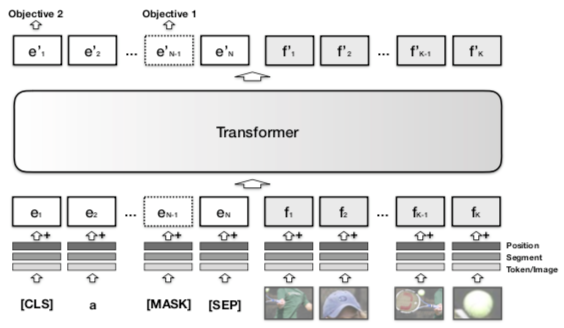

Architecture of VisualBERT, pre-trained in a multitask way  with a masked language modeling and sentence-image prediction task.

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### Lightning DataModule

In [ ]:
dm = Task3DataModule(
    train_st3_dir, train_data3,
    test_st3_dir, test_data3,
    dev_st3_dir, dev_data3,
    techniques=techniques,
    batch_size=8
)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(2)

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out

In [ ]:
class Task3VBModel(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 22,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        #self.loss = torch.nn.BCELoss()
        #self.loss = torch.nn.BCEWithLogitsLoss()
        self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        self.image_encoder = ImageEncoder()

        self.image_encoder.eval()
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        D_in, H, D_out = 768, 64, self.num_classes
        self.transformer = VisualBertModel.from_pretrained(
            "uclanlp/visualbert-vqa-coco-pre")

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        visual_embeds = self.image_encoder(inputs["images"])

        visual_token_type_ids = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.float, device=device)

        outputs = self.transformer(input_ids=inputs["input_ids"],
                                   attention_mask=inputs["attention_mask"],
                                   token_type_ids=inputs["token_type_ids"],
                                   visual_embeds=visual_embeds,
                                   visual_token_type_ids=visual_token_type_ids,
                                   visual_attention_mask=visual_attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        # optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


### Train and Validation

In [ ]:
model = Task3VBModel(dm.mlb, dm.y_train)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_VBRes_net", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## Visual BERT: FasterRCNN + Text-Transformer

VisualBERT structure is the same explained in the previous paragraph, but in this case the visual features are extracted from the image with [FasterRCNN](https://arxiv.org/pdf/1506.01497.pdf).

We used ResNet50 as backbone network and extracted the features from ROI heads: after the region proposal network and before the classification layers of FasterRCNN.

Note that FasterRCNN structure can be seen in paragraph: *DeBERTa + FasterRCNN Embeddings*

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### Lightning DataModule

In [ ]:
dm = Task3DataModule(
    train_st3_dir, train_data3,
    test_st3_dir, test_data3,
    dev_st3_dir, dev_data3,
    techniques=techniques,
    batch_size=8
)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = detection.fasterrcnn_resnet50_fpn(
            pretrained=True, progress=True, pretrained_backbone=True, rpn_post_nms_top_n_test=10)

        self.features = torch.Tensor()
        # you can also hook layers inside the roi_heads
        layer_to_hook = 'roi_heads.box_head.fc7'
        for name, layer in self.model.named_modules():
            if name == layer_to_hook:
                layer.register_forward_hook(self.save_features)

    def save_features(self, mod, inp, outp):
        self.features = outp.unsqueeze(-1).view(-1, 10, 1024)

    def get_roi_features(self):
        return self.features

    def forward(self, x):
        self.model.eval()
        self.model(x)
        features = self.features
        self.features = torch.Tensor()
        return features

In [ ]:
class Task3VBModel(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 22,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        #self.loss = torch.nn.BCEWithLogitsLoss()
        self.loss = FocalLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        self.image_encoder = ImageEncoder()
        self.image_encoder.eval()

        for param in self.image_encoder.parameters():
            param.requires_grad = False

        D_in, H, D_out = 768, 64, self.num_classes
        self.transformer = VisualBertModel.from_pretrained(
            "uclanlp/visualbert-nlvr2-coco-pre")

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        visual_embeds = self.image_encoder(inputs["images"])

        visual_token_type_ids = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.float, device=device)

        outputs = self.transformer(input_ids=inputs["input_ids"],
                                   attention_mask=inputs["attention_mask"],
                                   token_type_ids=inputs["token_type_ids"],
                                   visual_embeds=visual_embeds,
                                   visual_token_type_ids=visual_token_type_ids,
                                   visual_attention_mask=visual_attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        # optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


### Train and Validation

In [ ]:
model = Task3VBModel(dm.mlb, dm.y_train)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_VBFasterRCNN_net", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)


## DVTT

[Double Visual Textual Transformer ](https://aclanthology.org/2021.semeval-1.140/) architecture is made of two different transformers networks: one for text and the other for images but each network is conditioned by the other letting the text be enriched with visual information and vice-versa. Their output are then averaged to decide the output labels.

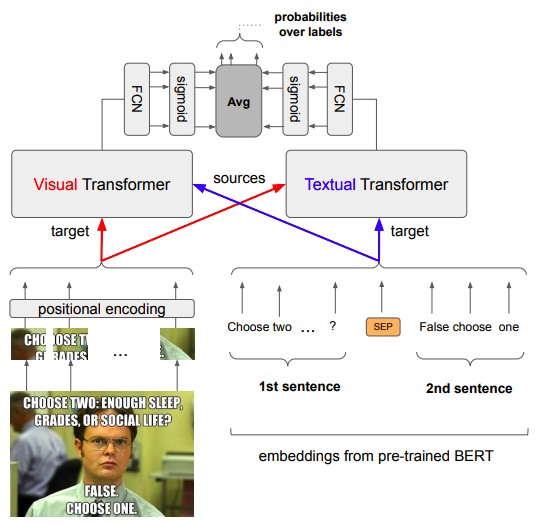

DVTT structure

As Image Encoder we used ResNet50, while for the text we used BERT base cased.

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
text_transformer_name = "bert-base-cased"

### Lightning DataModule

In [ ]:
dm = Task3DataModule(
    train_st3_dir, train_data3,
    test_st3_dir, test_data3,
    dev_st3_dir, dev_data3,
    techniques=techniques,
    model_name=text_transformer_name,
    batch_size=8
)
dm.setup()

### Model

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(2)

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name_or_path):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name_or_path)

    def forward(self, input_ids, attention_mask):
        out = self.model(input_ids=input_ids,
                         attention_mask=attention_mask)
        out = out.last_hidden_state
        return out  # BxTx768

In [ ]:
class DualTransformer(nn.Module):
    def __init__(
        self,
        num_classes: int = 22,
        embed_dim: int = 1024
    ):
        super().__init__()
        self.text_conditioned_on_image_transformer = nn.Transformer(d_model=embed_dim, nhead=4,
                                                                    dim_feedforward=1024,
                                                                    dropout=0.1, activation='relu',
                                                                    num_encoder_layers=4,
                                                                    num_decoder_layers=4,
                                                                    batch_first=True)
        self.image_conditioned_on_text_transformer = nn.Transformer(d_model=embed_dim, nhead=4,
                                                                    dim_feedforward=1024,
                                                                    dropout=0.1, activation='relu',
                                                                    num_encoder_layers=4,
                                                                    num_decoder_layers=4,
                                                                    batch_first=True)
        self.map_text = nn.Linear(768, embed_dim)
        self.map_image = nn.Linear(2048, embed_dim)

        self.text_classifier = nn.Linear(embed_dim, num_classes)
        self.image_classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, text, text_mask, image):
        text = self.map_text(text)
        image = self.map_image(image)

        pad_mask = ~text_mask.bool()

        # forward image transformer conditioned on the text
        image_out = self.image_conditioned_on_text_transformer(
            src=text, tgt=image, src_key_padding_mask=pad_mask, memory_key_padding_mask=pad_mask)
        cls_image = image_out[:, 0, :]
        image_class_logits = self.image_classifier(cls_image)

        # forward text transformer conditioned on the image
        text_out = self.text_conditioned_on_image_transformer(
            src=image, tgt=text, tgt_key_padding_mask=pad_mask)
        cls_text = text_out[:, 0, :]
        text_class_logits = self.text_classifier(cls_text)

        text_probs = torch.sigmoid(text_class_logits)
        image_probs = torch.sigmoid(image_class_logits)
        return (text_class_logits + image_class_logits) / 2


In [ ]:
class Task3DVTTModel(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        num_classes: int = 22,
        model_name_or_path: str = "bert-base-cased",
        learning_rate: float = 3e-5,
        adam_epsilon: float = 1e-8,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.mlb = mlb

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.threshold = 0.5

        self.num_classes = num_classes

        self.loss = torch.nn.BCEWithLogitsLoss()
        #self.loss = FocalLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder(model_name_or_path)
        self.classifier = DualTransformer(num_classes=self.num_classes)

        self.image_encoder.eval()
        self.text_encoder.eval()

        for param in self.image_encoder.parameters():
            param.requires_grad = False

        for param in self.text_encoder.parameters():
            param.requires_grad = False

    def forward(self, **inputs):
        image_features = self.image_encoder(inputs["images"])
        text_features = self.text_encoder(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

        logits = self.classifier(
            text_features, inputs["attention_mask"], image_features)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()

        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)

        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (logits > self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        #optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)

        return optimizer


### Train and Validation

In [ ]:
model = Task3DVTTModel(dm.mlb, dm.y_train,
                       model_name_or_path=text_transformer_name)

In [ ]:
log_dir = logs_dir+"SubTask3/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask3_DVTT_net", version="TEST", log_graph=True)

In [ ]:
trainer = Trainer(max_epochs=10, gpus=AVAIL_GPUS, logger=logger,
                  callbacks=[Task3EvaluateCallback()])

In [ ]:
trainer.fit(model, dm)

### Testing

In [ ]:
trainer.test(model, dm)

### Example prediction

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(model, predict_dataloader)

In [ ]:
texts = test_data3.text.values
labels_data = test_data3.labels.values
images = test_data3.image.values
for i in range(5):
    text = texts[i].replace('\\', "").replace('\n', ' ').strip()
    labels = labels_data[i]
    image = Image.open(test_st3_dir+images[i])
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Image:")
    plt.imshow(image)
    plt.show()
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

## Tensorboard: plots of the models

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/DeepProject/Logs/SubTask3/

## Final Results

The hyperparameters used during the experiments are reported in the following table:

|     Parameters    	|          	| VisualBERT 	|  DVTT 	| DeBERTa 	|  MMBT 	|
|:-----------------:	|:--------:	|:----------:	|:-----:	|:-------:	|:-----:	|
|    **Dropout**    	|          	|     0.1    	|  0.1  	|   0.2   	|  0.1  	|
|   **Batch Size**  	|     8    	|            	|       	|         	|       	|
| **Learning Rate** 	| 3,00E-05 	|            	|       	|         	|       	|
|   **Optimizer**   	|          	|    AdamW   	| AdamW 	|   Adam  	| AdamW 	|
|  **Adam Epsilon** 	| 1,00E-08 	|            	|       	|         	|       	|
|  **Weight Decay** 	|          	|     0.1    	|  0.1  	|    /    	|  0.1  	|
|     **Epochs**    	|    10    	|            	|       	|         	|       	|

We performed several tests, trying all the models with the three defined loss functions, and getting the following results:

|            Model            	|        Loss       	|    DEV-SET   	|    DEV-SET   	|   TEST-SET   	|   TEST-SET   	| Optimizer 	|
|:---------------------------:	|:-----------------:	|:------------:	|:------------:	|:------------:	|:------------:	|:---------:	|
|                             	|                   	| **F1-micro** 	| **F1-macro** 	| **F1-micro** 	| **F1-macro** 	|           	|
|                             	| BCEwithLogitsLoss 	|     0.38     	|     0.18     	|     0.29     	|     0.03     	|    Adam   	|
|    **DeBERTa + ResNet50**   	|  WeightedBCELoss  	|     0.27     	|     0.16     	|     0.26     	|     0.11     	|    Adam   	|
|                             	|     FocalLoss     	|     0.52     	|     0.22     	|     0.40     	|     0.07     	|    Adam   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|                             	| BCEwithLogitsLoss 	|     0.51     	|     0.21     	|     0.44     	|     0.06     	|    Adam   	|
|   **DeBERTa + FasterRCNN**  	|  WeightedBCELoss  	|     0.26     	|     0.20     	|     0.23     	|     0.10     	|    Adam   	|
|                             	|     FocalLoss     	|     0.51     	|     0.21     	|     0.44     	|     0.06     	|    Adam   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|                             	| BCEwithLogitsLoss 	|     0.55     	|     0.23     	|     0.48     	|     0.09     	|   AdamW   	|
|           **MMBT**          	|  WeightedBCELoss  	|     0.35     	|     0.20     	|     0.33     	|     0.13     	|   AdamW   	|
|                             	|     FocalLoss     	|     0.57     	|     0.24     	|     0.48     	|     0.10     	|   AdamW   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|                             	| BCEwithLogitsLoss 	|     0.56     	|     0.23     	|     0.44     	|     0.08     	|   AdamW   	|
|  **VisualBERT (ResNet50)**  	|  WeightedBCELoss  	|     0.27     	|     0.15     	|     0.26     	|     0.12     	|   AdamW   	|
|                             	|     FocalLoss     	|     0.54     	|     0.23     	|     0.44     	|     0.08     	|   AdamW   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|                             	| BCEwithLogitsLoss 	|     0.45     	|     0.20     	|     0.36     	|     0.05     	|   AdamW   	|
| **VisualBERT (FasterRCNN)** 	|  WeightedBCELoss  	|     0.22     	|     0.16     	|     0.20     	|     0.07     	|   AdamW   	|
|                             	|     FocalLoss     	|     0.54     	|     0.23     	|     0.45     	|     0.08     	|   AdamW   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|                             	| BCEwithLogitsLoss 	|     0.57     	|     0.23     	|     0.47     	|     0.08     	|   AdamW   	|
|           **DVTT**          	|  WeightedBCELoss  	|     0.57     	|     0.24     	|     0.41     	|     0.15     	|   AdamW   	|
|                             	|     FocalLoss     	|     0.53     	|     0.23     	|     0.46     	|     0.08     	|   AdamW   	|
|                             	|                   	|              	|              	|              	|              	|           	|
|     **Random Baseline**     	|                   	|     0.067    	|     0.064    	|     0.066    	|     0.040    	|           	|

From the table, we can observe that in general Weighted BCE Loss achieves worse performace w.r.t. the others, and that
using Focal Loss is, in most cases, a good strategy.

The best performing model is MMBT (MultiModal BiTransformers) with FocalLoss (F1-Micro of 0.48 and F1-Macro of 0.10 with the test set).